# Задача классификации текста с использованием архитектуры LSTM.

## Датасет IMDB Dataset of 50K Movie Reviews:

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

**review:** отзыв.

**sentiment:** позитивный или негативный.


In [123]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import gensim
import nltk
import numpy as np

from torch.utils.data import Sampler
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import FastText, KeyedVectors
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
import nltk, spacy, os
nltk.download("punkt"); nltk.download("stopwords"); nltk.download("wordnet"); nltk.download("omw-1.4")

In [83]:
df = pd.read_csv(r'C:\Users\555\Desktop\LS\MLA\NLP\practice\FakeNewsNet.csv', encoding='utf-8')

In [7]:
df.shape

(23196, 5)

In [9]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [11]:
print(df.isnull().sum())

title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64


In [13]:
df['real'].value_counts()

real
1    17441
0     5755
Name: count, dtype: int64

In [85]:
df = df.dropna(subset=['news_url', 'source_domain']).reset_index(drop=True)

In [87]:
df['text'] = df['title'] + ' ' + df['news_url'] + ' ' + df['source_domain']

In [89]:
df = df[['text', 'real']]  # Оставляем только текст и метку

In [91]:
df.head()

,text,real
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\555\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


count    22866.000000
mean        16.481632
std          4.933526
min          3.000000
25%         13.000000
50%         16.000000
75%         19.000000
max         57.000000
Name: length, dtype: float64


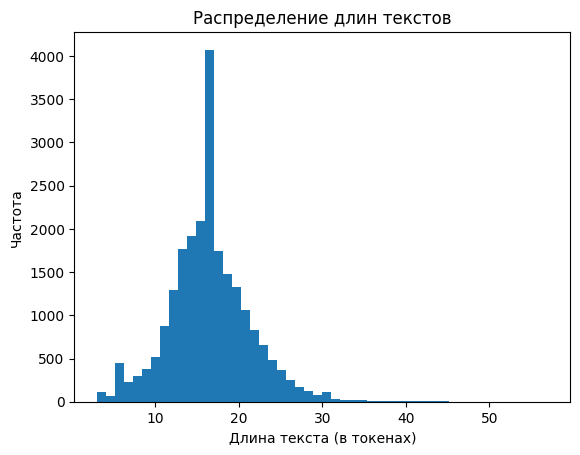

In [93]:
# Токенизация
nltk.download('punkt')
df['tokens'] = df['text'].apply(lambda x: word_tokenize(x.lower()))

# Преобразуем метки в числа (0 или 1)
df['label'] = df['real']

# Собираем все токены
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab_counter = Counter(all_tokens)

# Создаем словарь: слово -> индекс
vocab = {word: idx + 2 for idx, (word, count) in enumerate(vocab_counter.items())}  # +2 для PAD и UNK
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Функция для преобразования токенов в индексы
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

df['indices'] = df['tokens'].apply(lambda x: tokens_to_indices(x, vocab))

# Посчитаем длины текстов (по токенам)
df['length'] = df['tokens'].apply(len)

# Посмотрим на базовую статистику
print(df['length'].describe())

# Построим гистограмму
plt.hist(df['length'], bins=50)
plt.xlabel('Длина текста (в токенах)')
plt.ylabel('Частота')
plt.title('Распределение длин текстов')
plt.show()

In [94]:
# Создаем класс TextDataset
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx], dtype=torch.float)

# Паддинг
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<PAD>'])
    labels = torch.stack(labels)
    return texts_padded, labels

# Самплер с "бакетами"
class BucketBatchSampler(Sampler):
    def __init__(self, lengths, batch_size, shuffle=True):
        self.lengths = np.array(lengths)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batches = self._create_batches()

    def _create_batches(self):
        sorted_indices = np.argsort(self.lengths)
        batches = [sorted_indices[i:i + self.batch_size] for i in range(0, len(sorted_indices), self.batch_size)]
        return batches

    def __iter__(self):
        if self.shuffle:
            np.random.shuffle(self.batches)
        for batch in self.batches:
            yield batch

    def __len__(self):
        return len(self.batches)

# Делим на train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(df['indices'], df['label'], test_size=0.2, random_state=42)

train_dataset = TextDataset(list(train_texts), list(train_labels))
test_dataset = TextDataset(list(test_texts), list(test_labels))

# Длины для BucketSampler только для train
train_lengths = [len(seq) for seq in train_texts]

# Batch size
batch_size = 32

# Самплер для train
train_sampler = BucketBatchSampler(train_lengths, batch_size=batch_size)

# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Проверим, как выглядит один батч
for batch_texts, batch_labels in train_loader:
    print(f"Batch texts shape: {batch_texts.shape}")  # (batch_size, seq_len)
    print(f"Batch labels shape: {batch_labels.shape}")  # (batch_size,)
    break

Batch texts shape: torch.Size([32, 14])
Batch labels shape: torch.Size([32])


In [97]:
# Глобальные параметры
INPUT_DIM = len(vocab)   # Размер словаря
EMBEDDING_DIM = 128      # Размерность эмбеддингов
OUTPUT_DIM = 1           # Для бинарной классификации
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Параметры для каждой модели
model_configs = {
    'RNN': {'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'n_epochs': 20},
    'LSTM': {'hidden_dim': 64, 'n_layers': 2, 'dropout': 0.5, 'n_epochs': 20},
    'GRU': {'hidden_dim': 64, 'n_layers': 2, 'dropout': 0.5, 'n_epochs': 20},
    'FFNN': {'hidden_dim': 128, 'dropout': 0.5, 'n_epochs': 20}  # без n_layers, так как FFNN простой
}

In [99]:
# Универсальный класс модели для RNN, LSTM, GRU, FFNN
class BaseTextModel(nn.Module):
    def __init__(self, embedding_layer, model_type, hidden_dim, output_dim, n_layers=None, dropout=0.5):
        super().__init__()
        self.embedding = embedding_layer
        
        if model_type == 'FFNN':
            # Для FFNN просто агрегируем эмбеддинги (усредняем по токенам)
            self.fc1 = nn.Linear(embedding_layer.embedding_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, output_dim)
            self.dropout = nn.Dropout(dropout)
            self.model_type = model_type
        
        else:
            # Для RNN, LSTM, GRU
            if model_type == 'RNN':
                self.rnn = nn.RNN(embedding_layer.embedding_dim, hidden_dim, n_layers, 
                                  dropout=dropout, batch_first=True)
            elif model_type == 'LSTM':
                self.rnn = nn.LSTM(embedding_layer.embedding_dim, hidden_dim, n_layers, 
                                   dropout=dropout, batch_first=True)
            elif model_type == 'GRU':
                self.rnn = nn.GRU(embedding_layer.embedding_dim, hidden_dim, n_layers, 
                                  dropout=dropout, batch_first=True)
            else:
                raise ValueError("Invalid model_type")
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.dropout = nn.Dropout(dropout)
            self.model_type = model_type

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))

        if self.model_type == 'FFNN':
            # Усредняем эмбеддинги по токенам (batch_size, seq_len, emb_dim) -> (batch_size, emb_dim)
            pooled = embedded.mean(dim=1)
            out = self.dropout(torch.relu(self.fc1(pooled)))
            return self.fc2(out)
        else:
            output, hidden = self.rnn(embedded)
            if isinstance(hidden, tuple):  # LSTM -> (hidden, cell)
                hidden = hidden[0]
            hidden = self.dropout(hidden[-1])  # Последний слой hidden state
            return self.fc(hidden)

# Функция для тренировки модели
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch in train_loader:
        optimizer.zero_grad()
        texts, labels = batch[0].to(device), batch[1].to(device)
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(train_loader), epoch_acc / len(train_loader)

# Функция для оценки модели
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            texts, labels = batch[0].to(device), batch[1].to(device)
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            all_predictions += predictions.tolist()
            all_labels += labels.tolist()

    return epoch_loss / len(test_loader), epoch_acc / len(test_loader), all_predictions, all_labels

# Вспомогательная функция для расчета бинарной точности
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

# Функция для вывода финальных метрик
def compute_metrics(predictions, labels):
    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)
    y_pred_binary = torch.round(torch.sigmoid(predictions)).numpy()
    y_true = labels.numpy()
    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, predictions.numpy())
    return accuracy, f1, roc_auc

In [101]:
# Функция обучения модели
def train_model(model, train_loader, optimizer, criterion, n_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            optimizer.zero_grad()
            predictions = model(batch[0].to(device)).squeeze(1)
            loss = criterion(predictions, batch[1].to(device))
            acc = binary_accuracy(predictions, batch[1].to(device))

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            all_predictions += predictions.tolist()
            all_labels += batch[1].tolist()

        all_predictions = torch.tensor(all_predictions).to(device)
        all_labels = torch.tensor(all_labels).to(device)
        val_acc = binary_accuracy(all_predictions, all_labels)
        val_loss = criterion(all_predictions, all_labels).item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(epoch_acc / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Epoch: {epoch+1:02}, Train Loss: {epoch_loss/len(train_loader):.3f}, Train Acc: {epoch_acc/len(train_loader)*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Функция оценки модели
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            predictions = model(batch[0].to(device)).squeeze(1)
            all_predictions += predictions.tolist()
            all_labels += batch[1].tolist()

    all_predictions = torch.tensor(all_predictions).to(device)
    all_labels = torch.tensor(all_labels).to(device)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, f1, roc_auc

# Функция визуализации тренировки
def plot_training(train_losses, train_accuracies, val_losses, val_accuracies, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


=== Embedding: Custom ===

--- Model: RNN ---


  5%|▌         | 1/20 [00:02<00:56,  2.98s/it]

Epoch: 01, Train Loss: 0.072, Train Acc: 96.33%, Val Loss: 0.072, Val Acc: 96.36%


 10%|█         | 2/20 [00:05<00:50,  2.83s/it]

Epoch: 02, Train Loss: 0.050, Train Acc: 97.63%, Val Loss: 0.050, Val Acc: 97.66%


 15%|█▌        | 3/20 [00:08<00:47,  2.77s/it]

Epoch: 03, Train Loss: 0.042, Train Acc: 97.54%, Val Loss: 0.042, Val Acc: 97.58%


 20%|██        | 4/20 [00:11<00:43,  2.73s/it]

Epoch: 04, Train Loss: 0.044, Train Acc: 97.42%, Val Loss: 0.043, Val Acc: 97.44%


 25%|██▌       | 5/20 [00:13<00:41,  2.74s/it]

Epoch: 05, Train Loss: 0.041, Train Acc: 97.69%, Val Loss: 0.039, Val Acc: 97.73%


 30%|███       | 6/20 [00:16<00:38,  2.72s/it]

Epoch: 06, Train Loss: 0.027, Train Acc: 98.28%, Val Loss: 0.027, Val Acc: 98.31%


 35%|███▌      | 7/20 [00:19<00:35,  2.71s/it]

Epoch: 07, Train Loss: 0.023, Train Acc: 98.35%, Val Loss: 0.023, Val Acc: 98.39%


 40%|████      | 8/20 [00:21<00:32,  2.70s/it]

Epoch: 08, Train Loss: 0.020, Train Acc: 98.46%, Val Loss: 0.020, Val Acc: 98.49%


 45%|████▌     | 9/20 [00:24<00:29,  2.69s/it]

Epoch: 09, Train Loss: 0.017, Train Acc: 98.69%, Val Loss: 0.017, Val Acc: 98.72%


 50%|█████     | 10/20 [00:27<00:27,  2.74s/it]

Epoch: 10, Train Loss: 0.013, Train Acc: 99.00%, Val Loss: 0.013, Val Acc: 99.04%


 55%|█████▌    | 11/20 [00:30<00:25,  2.84s/it]

Epoch: 11, Train Loss: 0.016, Train Acc: 99.04%, Val Loss: 0.015, Val Acc: 99.07%


 60%|██████    | 12/20 [00:33<00:22,  2.83s/it]

Epoch: 12, Train Loss: 0.012, Train Acc: 99.10%, Val Loss: 0.012, Val Acc: 99.14%


 65%|██████▌   | 13/20 [00:36<00:19,  2.81s/it]

Epoch: 13, Train Loss: 0.009, Train Acc: 99.41%, Val Loss: 0.009, Val Acc: 99.44%


 70%|███████   | 14/20 [00:38<00:16,  2.80s/it]

Epoch: 14, Train Loss: 0.007, Train Acc: 99.46%, Val Loss: 0.006, Val Acc: 99.50%


 75%|███████▌  | 15/20 [00:41<00:13,  2.78s/it]

Epoch: 15, Train Loss: 0.008, Train Acc: 99.38%, Val Loss: 0.008, Val Acc: 99.42%


 80%|████████  | 16/20 [00:44<00:11,  2.79s/it]

Epoch: 16, Train Loss: 0.008, Train Acc: 99.40%, Val Loss: 0.008, Val Acc: 99.43%


 85%|████████▌ | 17/20 [00:47<00:08,  2.79s/it]

Epoch: 17, Train Loss: 0.009, Train Acc: 99.39%, Val Loss: 0.009, Val Acc: 99.43%


 90%|█████████ | 18/20 [00:49<00:05,  2.79s/it]

Epoch: 18, Train Loss: 0.005, Train Acc: 99.62%, Val Loss: 0.005, Val Acc: 99.66%


 95%|█████████▌| 19/20 [00:52<00:02,  2.80s/it]

Epoch: 19, Train Loss: 0.005, Train Acc: 99.54%, Val Loss: 0.005, Val Acc: 99.57%


100%|██████████| 20/20 [00:55<00:00,  2.78s/it]

Epoch: 20, Train Loss: 0.004, Train Acc: 99.77%, Val Loss: 0.003, Val Acc: 99.79%


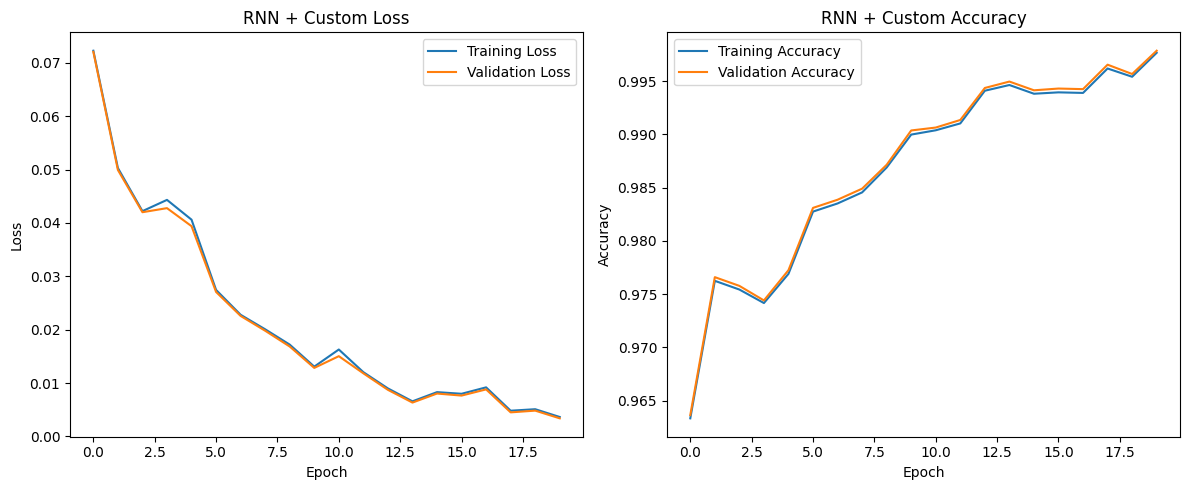

100%|██████████| 143/143 [00:00<00:00, 673.86it/s]


Accuracy: 0.3170091823349366
F1 Score: 0.18348144276006273
ROC AUC Score: 0.8747538965028324


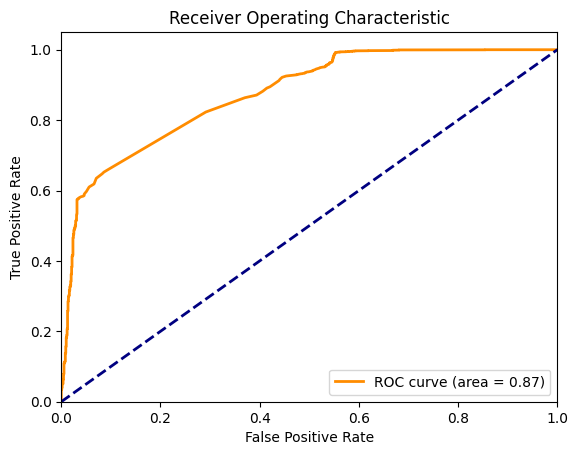


--- Model: LSTM ---


  5%|▌         | 1/20 [00:03<00:59,  3.12s/it]

Epoch: 01, Train Loss: 0.065, Train Acc: 96.93%, Val Loss: 0.064, Val Acc: 96.95%


 10%|█         | 2/20 [00:06<00:56,  3.12s/it]

Epoch: 02, Train Loss: 0.020, Train Acc: 98.81%, Val Loss: 0.020, Val Acc: 98.84%


 15%|█▌        | 3/20 [00:09<00:52,  3.06s/it]

Epoch: 03, Train Loss: 0.011, Train Acc: 99.34%, Val Loss: 0.011, Val Acc: 99.34%


 20%|██        | 4/20 [00:12<00:48,  3.02s/it]

Epoch: 04, Train Loss: 0.010, Train Acc: 99.34%, Val Loss: 0.010, Val Acc: 99.37%


 25%|██▌       | 5/20 [00:15<00:44,  2.98s/it]

Epoch: 05, Train Loss: 0.009, Train Acc: 99.37%, Val Loss: 0.008, Val Acc: 99.38%


 30%|███       | 6/20 [00:18<00:41,  2.96s/it]

Epoch: 06, Train Loss: 0.008, Train Acc: 99.54%, Val Loss: 0.008, Val Acc: 99.55%


 35%|███▌      | 7/20 [00:20<00:38,  2.96s/it]

Epoch: 07, Train Loss: 0.005, Train Acc: 99.67%, Val Loss: 0.005, Val Acc: 99.67%


 40%|████      | 8/20 [00:23<00:35,  2.96s/it]

Epoch: 08, Train Loss: 0.005, Train Acc: 99.69%, Val Loss: 0.005, Val Acc: 99.69%


 45%|████▌     | 9/20 [00:26<00:32,  2.96s/it]

Epoch: 09, Train Loss: 0.005, Train Acc: 99.67%, Val Loss: 0.005, Val Acc: 99.69%


 50%|█████     | 10/20 [00:29<00:29,  2.96s/it]

Epoch: 10, Train Loss: 0.005, Train Acc: 99.70%, Val Loss: 0.005, Val Acc: 99.70%


 55%|█████▌    | 11/20 [00:32<00:26,  2.97s/it]

Epoch: 11, Train Loss: 0.006, Train Acc: 99.60%, Val Loss: 0.006, Val Acc: 99.62%


 60%|██████    | 12/20 [00:35<00:23,  3.00s/it]

Epoch: 12, Train Loss: 0.004, Train Acc: 99.82%, Val Loss: 0.004, Val Acc: 99.82%


 65%|██████▌   | 13/20 [00:38<00:21,  3.01s/it]

Epoch: 13, Train Loss: 0.002, Train Acc: 99.84%, Val Loss: 0.002, Val Acc: 99.84%


 70%|███████   | 14/20 [00:41<00:17,  2.99s/it]

Epoch: 14, Train Loss: 0.002, Train Acc: 99.85%, Val Loss: 0.002, Val Acc: 99.86%


 75%|███████▌  | 15/20 [00:44<00:14,  2.98s/it]

Epoch: 15, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.87%


 80%|████████  | 16/20 [00:47<00:11,  2.96s/it]

Epoch: 16, Train Loss: 0.001, Train Acc: 99.90%, Val Loss: 0.001, Val Acc: 99.91%


 85%|████████▌ | 17/20 [00:50<00:08,  2.93s/it]

Epoch: 17, Train Loss: 0.001, Train Acc: 99.92%, Val Loss: 0.001, Val Acc: 99.92%


 90%|█████████ | 18/20 [00:53<00:05,  2.92s/it]

Epoch: 18, Train Loss: 0.002, Train Acc: 99.91%, Val Loss: 0.002, Val Acc: 99.91%


 95%|█████████▌| 19/20 [00:56<00:02,  2.92s/it]

Epoch: 19, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.88%


100%|██████████| 20/20 [00:59<00:00,  2.97s/it]

Epoch: 20, Train Loss: 0.001, Train Acc: 99.95%, Val Loss: 0.001, Val Acc: 99.95%


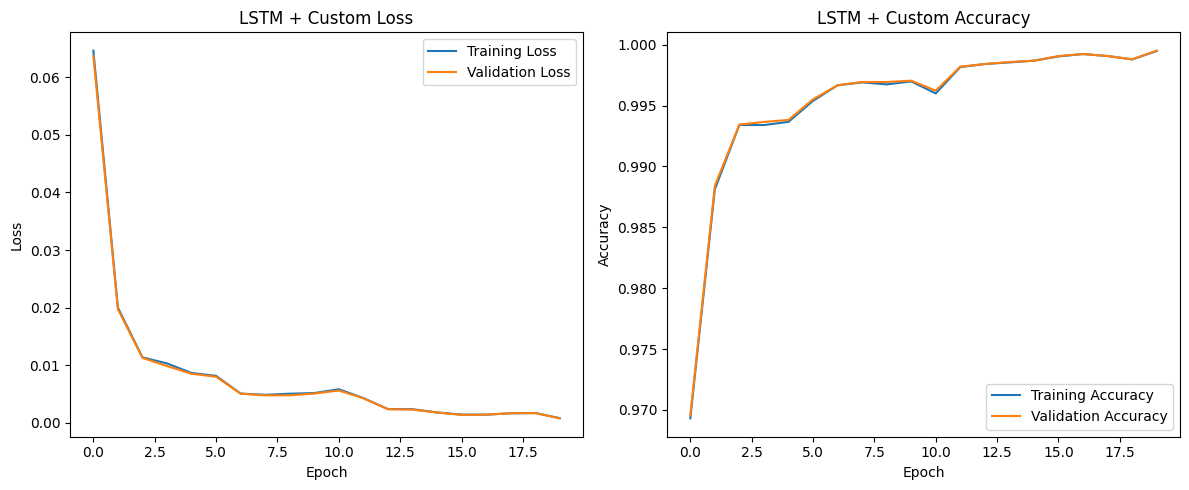

100%|██████████| 143/143 [00:00<00:00, 720.27it/s]

Accuracy: 0.8937472671622213
F1 Score: 0.9344836883256943
ROC AUC Score: 0.9933758473564827


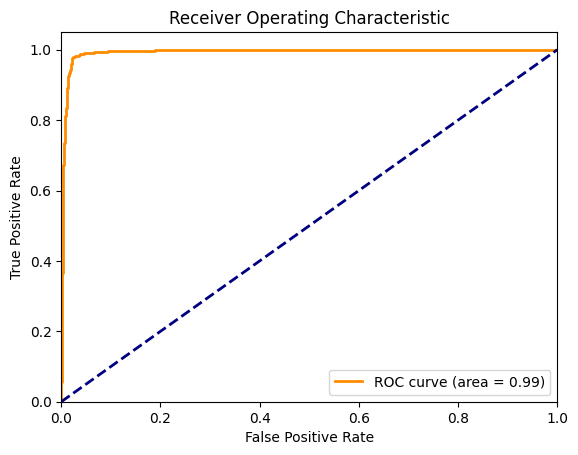


--- Model: GRU ---


  5%|▌         | 1/20 [00:02<00:55,  2.93s/it]

Epoch: 01, Train Loss: 0.045, Train Acc: 97.94%, Val Loss: 0.043, Val Acc: 97.97%


 10%|█         | 2/20 [00:05<00:53,  2.95s/it]

Epoch: 02, Train Loss: 0.012, Train Acc: 99.37%, Val Loss: 0.012, Val Acc: 99.39%


 15%|█▌        | 3/20 [00:08<00:50,  2.99s/it]

Epoch: 03, Train Loss: 0.006, Train Acc: 99.65%, Val Loss: 0.006, Val Acc: 99.68%


 20%|██        | 4/20 [00:12<00:48,  3.04s/it]

Epoch: 04, Train Loss: 0.005, Train Acc: 99.71%, Val Loss: 0.005, Val Acc: 99.71%


 25%|██▌       | 5/20 [00:15<00:45,  3.02s/it]

Epoch: 05, Train Loss: 0.003, Train Acc: 99.82%, Val Loss: 0.003, Val Acc: 99.83%


 30%|███       | 6/20 [00:18<00:42,  3.02s/it]

Epoch: 06, Train Loss: 0.003, Train Acc: 99.82%, Val Loss: 0.003, Val Acc: 99.82%


 35%|███▌      | 7/20 [00:21<00:39,  3.02s/it]

Epoch: 07, Train Loss: 0.002, Train Acc: 99.91%, Val Loss: 0.002, Val Acc: 99.91%


 40%|████      | 8/20 [00:24<00:35,  2.99s/it]

Epoch: 08, Train Loss: 0.002, Train Acc: 99.91%, Val Loss: 0.002, Val Acc: 99.91%


 45%|████▌     | 9/20 [00:27<00:33,  3.01s/it]

Epoch: 09, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.88%


 50%|█████     | 10/20 [00:29<00:29,  2.98s/it]

Epoch: 10, Train Loss: 0.002, Train Acc: 99.92%, Val Loss: 0.002, Val Acc: 99.92%


 55%|█████▌    | 11/20 [00:32<00:26,  2.96s/it]

Epoch: 11, Train Loss: 0.002, Train Acc: 99.92%, Val Loss: 0.002, Val Acc: 99.92%


 60%|██████    | 12/20 [00:35<00:23,  2.95s/it]

Epoch: 12, Train Loss: 0.001, Train Acc: 99.90%, Val Loss: 0.001, Val Acc: 99.90%


 65%|██████▌   | 13/20 [00:38<00:20,  2.94s/it]

Epoch: 13, Train Loss: 0.002, Train Acc: 99.89%, Val Loss: 0.002, Val Acc: 99.89%


 70%|███████   | 14/20 [00:41<00:17,  2.95s/it]

Epoch: 14, Train Loss: 0.001, Train Acc: 99.91%, Val Loss: 0.001, Val Acc: 99.91%


 75%|███████▌  | 15/20 [00:44<00:14,  2.95s/it]

Epoch: 15, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.96%


 80%|████████  | 16/20 [00:47<00:11,  2.99s/it]

Epoch: 16, Train Loss: 0.001, Train Acc: 99.93%, Val Loss: 0.001, Val Acc: 99.93%


 85%|████████▌ | 17/20 [00:50<00:09,  3.01s/it]

Epoch: 17, Train Loss: 0.001, Train Acc: 99.93%, Val Loss: 0.001, Val Acc: 99.93%


 90%|█████████ | 18/20 [00:53<00:05,  2.98s/it]

Epoch: 18, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 95%|█████████▌| 19/20 [00:56<00:02,  2.98s/it]

Epoch: 19, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.96%


100%|██████████| 20/20 [00:59<00:00,  2.99s/it]

Epoch: 20, Train Loss: 0.001, Train Acc: 99.94%, Val Loss: 0.001, Val Acc: 99.94%


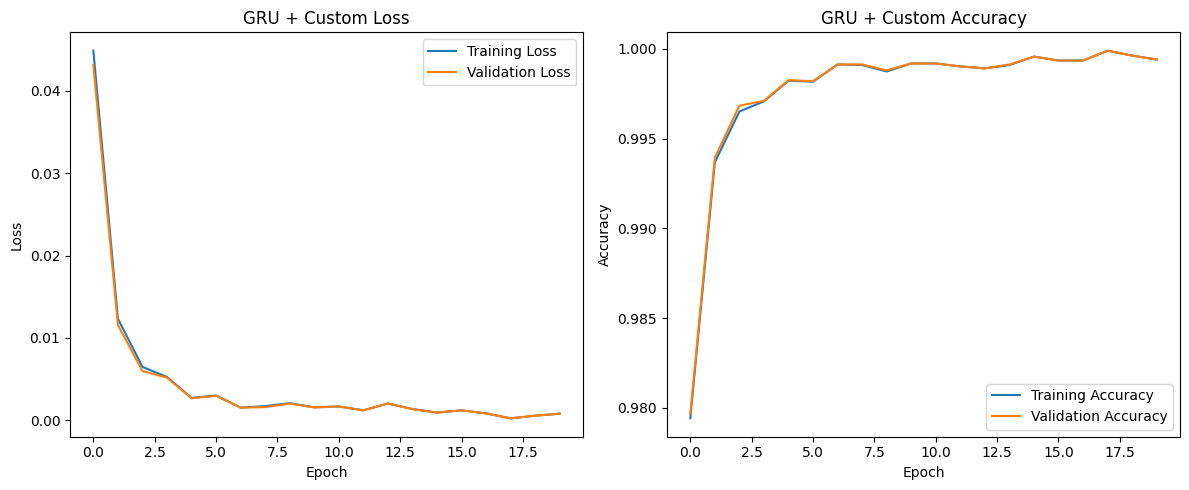

100%|██████████| 143/143 [00:00<00:00, 734.67it/s]


Accuracy: 0.9868823786620026
F1 Score: 0.9913892078071183
ROC AUC Score: 0.9936727237627649


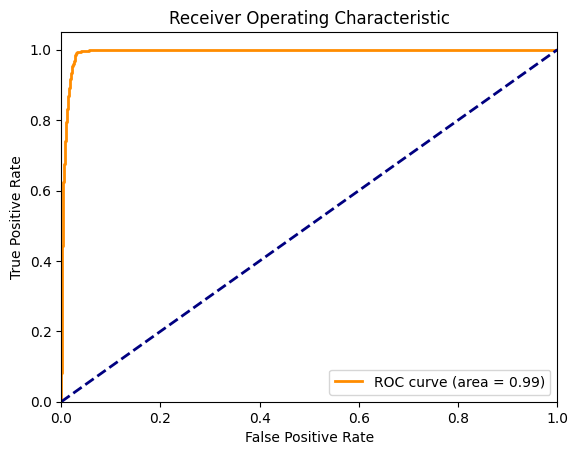


--- Model: FFNN ---


  5%|▌         | 1/20 [00:02<00:44,  2.36s/it]

Epoch: 01, Train Loss: 0.095, Train Acc: 95.00%, Val Loss: 0.095, Val Acc: 95.01%


 10%|█         | 2/20 [00:04<00:40,  2.23s/it]

Epoch: 02, Train Loss: 0.037, Train Acc: 97.76%, Val Loss: 0.036, Val Acc: 97.77%


 15%|█▌        | 3/20 [00:06<00:37,  2.20s/it]

Epoch: 03, Train Loss: 0.023, Train Acc: 98.55%, Val Loss: 0.023, Val Acc: 98.56%


 20%|██        | 4/20 [00:08<00:34,  2.18s/it]

Epoch: 04, Train Loss: 0.015, Train Acc: 99.08%, Val Loss: 0.015, Val Acc: 99.09%


 25%|██▌       | 5/20 [00:10<00:32,  2.17s/it]

Epoch: 05, Train Loss: 0.013, Train Acc: 99.22%, Val Loss: 0.013, Val Acc: 99.22%


 30%|███       | 6/20 [00:13<00:30,  2.17s/it]

Epoch: 06, Train Loss: 0.008, Train Acc: 99.49%, Val Loss: 0.008, Val Acc: 99.50%


 35%|███▌      | 7/20 [00:15<00:28,  2.17s/it]

Epoch: 07, Train Loss: 0.009, Train Acc: 99.47%, Val Loss: 0.009, Val Acc: 99.48%


 40%|████      | 8/20 [00:17<00:26,  2.19s/it]

Epoch: 08, Train Loss: 0.008, Train Acc: 99.53%, Val Loss: 0.008, Val Acc: 99.53%


 45%|████▌     | 9/20 [00:19<00:24,  2.19s/it]

Epoch: 09, Train Loss: 0.006, Train Acc: 99.67%, Val Loss: 0.006, Val Acc: 99.68%


 50%|█████     | 10/20 [00:21<00:21,  2.19s/it]

Epoch: 10, Train Loss: 0.005, Train Acc: 99.72%, Val Loss: 0.005, Val Acc: 99.73%


 55%|█████▌    | 11/20 [00:24<00:19,  2.18s/it]

Epoch: 11, Train Loss: 0.004, Train Acc: 99.74%, Val Loss: 0.004, Val Acc: 99.74%


 60%|██████    | 12/20 [00:26<00:17,  2.18s/it]

Epoch: 12, Train Loss: 0.005, Train Acc: 99.70%, Val Loss: 0.005, Val Acc: 99.70%


 65%|██████▌   | 13/20 [00:28<00:15,  2.18s/it]

Epoch: 13, Train Loss: 0.004, Train Acc: 99.74%, Val Loss: 0.004, Val Acc: 99.75%


 70%|███████   | 14/20 [00:30<00:13,  2.18s/it]

Epoch: 14, Train Loss: 0.004, Train Acc: 99.80%, Val Loss: 0.004, Val Acc: 99.80%


 75%|███████▌  | 15/20 [00:32<00:10,  2.19s/it]

Epoch: 15, Train Loss: 0.003, Train Acc: 99.82%, Val Loss: 0.003, Val Acc: 99.82%


 80%|████████  | 16/20 [00:34<00:08,  2.19s/it]

Epoch: 16, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.88%


 85%|████████▌ | 17/20 [00:37<00:06,  2.17s/it]

Epoch: 17, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.87%


 90%|█████████ | 18/20 [00:39<00:04,  2.17s/it]

Epoch: 18, Train Loss: 0.002, Train Acc: 99.86%, Val Loss: 0.002, Val Acc: 99.86%


 95%|█████████▌| 19/20 [00:41<00:02,  2.16s/it]

Epoch: 19, Train Loss: 0.002, Train Acc: 99.86%, Val Loss: 0.002, Val Acc: 99.86%


100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


Epoch: 20, Train Loss: 0.002, Train Acc: 99.85%, Val Loss: 0.002, Val Acc: 99.85%


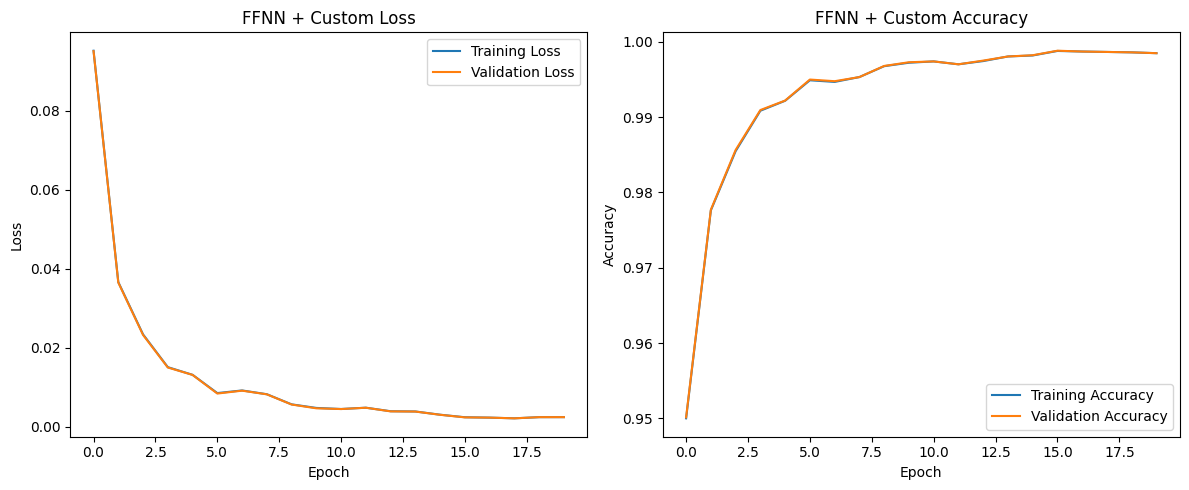

100%|██████████| 143/143 [00:00<00:00, 835.56it/s]


Accuracy: 0.9678618277219064
F1 Score: 0.9785745518146043
ROC AUC Score: 0.9944725682809212


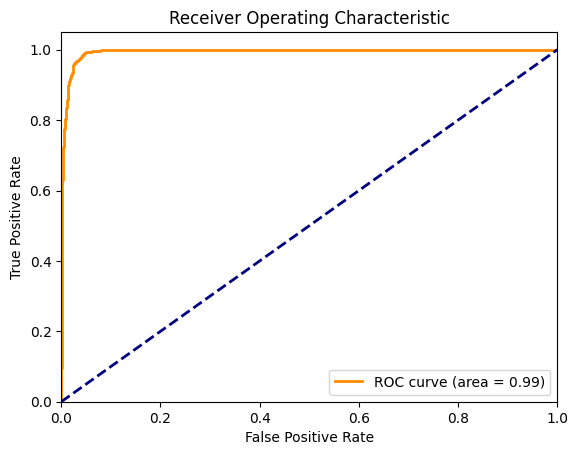


=== Embedding: Word2Vec ===

--- Model: RNN ---


  5%|▌         | 1/20 [00:02<00:54,  2.88s/it]

Epoch: 01, Train Loss: 0.067, Train Acc: 97.01%, Val Loss: 0.066, Val Acc: 97.04%


 10%|█         | 2/20 [00:05<00:50,  2.80s/it]

Epoch: 02, Train Loss: 0.047, Train Acc: 97.51%, Val Loss: 0.047, Val Acc: 97.55%


 15%|█▌        | 3/20 [00:08<00:47,  2.78s/it]

Epoch: 03, Train Loss: 0.031, Train Acc: 98.21%, Val Loss: 0.030, Val Acc: 98.25%


 20%|██        | 4/20 [00:11<00:44,  2.78s/it]

Epoch: 04, Train Loss: 0.012, Train Acc: 99.36%, Val Loss: 0.011, Val Acc: 99.40%


 25%|██▌       | 5/20 [00:13<00:41,  2.79s/it]

Epoch: 05, Train Loss: 0.007, Train Acc: 99.84%, Val Loss: 0.005, Val Acc: 99.86%


 30%|███       | 6/20 [00:16<00:38,  2.79s/it]

Epoch: 06, Train Loss: 0.004, Train Acc: 99.82%, Val Loss: 0.004, Val Acc: 99.85%


 35%|███▌      | 7/20 [00:19<00:36,  2.78s/it]

Epoch: 07, Train Loss: 0.008, Train Acc: 99.57%, Val Loss: 0.008, Val Acc: 99.57%


 40%|████      | 8/20 [00:22<00:33,  2.78s/it]

Epoch: 08, Train Loss: 0.002, Train Acc: 99.96%, Val Loss: 0.002, Val Acc: 99.96%


 45%|████▌     | 9/20 [00:25<00:30,  2.77s/it]

Epoch: 09, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.88%


 50%|█████     | 10/20 [00:27<00:27,  2.76s/it]

Epoch: 10, Train Loss: 0.001, Train Acc: 99.99%, Val Loss: 0.001, Val Acc: 99.99%


 55%|█████▌    | 11/20 [00:30<00:24,  2.78s/it]

Epoch: 11, Train Loss: 0.001, Train Acc: 99.97%, Val Loss: 0.001, Val Acc: 99.97%


 60%|██████    | 12/20 [00:33<00:22,  2.77s/it]

Epoch: 12, Train Loss: 0.002, Train Acc: 99.89%, Val Loss: 0.002, Val Acc: 99.91%


 65%|██████▌   | 13/20 [00:36<00:19,  2.76s/it]

Epoch: 13, Train Loss: 0.001, Train Acc: 99.97%, Val Loss: 0.001, Val Acc: 99.97%


 70%|███████   | 14/20 [00:38<00:16,  2.75s/it]

Epoch: 14, Train Loss: 0.004, Train Acc: 99.83%, Val Loss: 0.003, Val Acc: 99.85%


 75%|███████▌  | 15/20 [00:41<00:13,  2.74s/it]

Epoch: 15, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 80%|████████  | 16/20 [00:44<00:11,  2.76s/it]

Epoch: 16, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 85%|████████▌ | 17/20 [00:47<00:08,  2.77s/it]

Epoch: 17, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.97%


 90%|█████████ | 18/20 [00:49<00:05,  2.76s/it]

Epoch: 18, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.97%


 95%|█████████▌| 19/20 [00:52<00:02,  2.79s/it]

Epoch: 19, Train Loss: 0.001, Train Acc: 99.93%, Val Loss: 0.001, Val Acc: 99.93%


100%|██████████| 20/20 [00:55<00:00,  2.77s/it]

Epoch: 20, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.91%


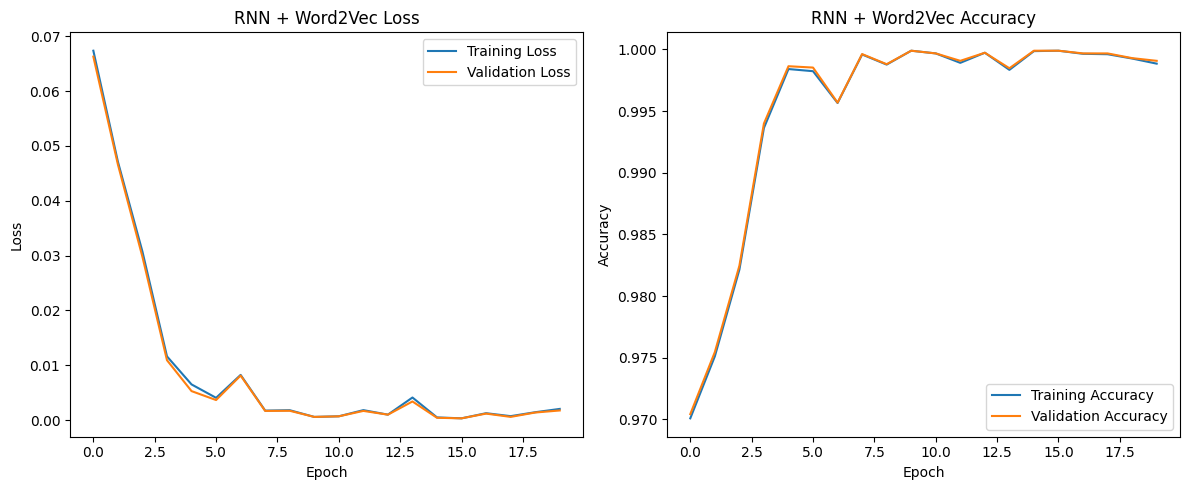

100%|██████████| 143/143 [00:00<00:00, 695.48it/s]

Accuracy: 0.8924355050284215
F1 Score: 0.9238861386138614
ROC AUC Score: 0.9590100554491039


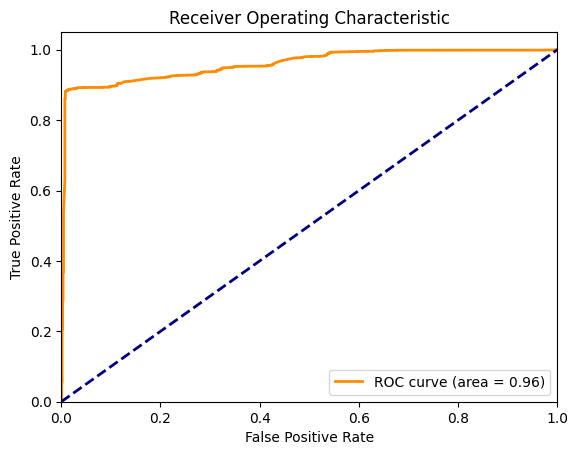


--- Model: LSTM ---


  5%|▌         | 1/20 [00:02<00:54,  2.86s/it]

Epoch: 01, Train Loss: 0.034, Train Acc: 98.71%, Val Loss: 0.034, Val Acc: 98.75%


 10%|█         | 2/20 [00:05<00:52,  2.93s/it]

Epoch: 02, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.89%


 15%|█▌        | 3/20 [00:08<00:49,  2.89s/it]

Epoch: 03, Train Loss: 0.003, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.90%


 20%|██        | 4/20 [00:11<00:45,  2.85s/it]

Epoch: 04, Train Loss: 0.001, Train Acc: 99.98%, Val Loss: 0.001, Val Acc: 99.98%


 25%|██▌       | 5/20 [00:14<00:42,  2.84s/it]

Epoch: 05, Train Loss: 0.000, Train Acc: 99.97%, Val Loss: 0.000, Val Acc: 99.97%


 30%|███       | 6/20 [00:17<00:39,  2.85s/it]

Epoch: 06, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 35%|███▌      | 7/20 [00:20<00:37,  2.85s/it]

Epoch: 07, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 40%|████      | 8/20 [00:22<00:34,  2.87s/it]

Epoch: 08, Train Loss: 0.001, Train Acc: 99.97%, Val Loss: 0.001, Val Acc: 99.97%


 45%|████▌     | 9/20 [00:25<00:31,  2.87s/it]

Epoch: 09, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 50%|█████     | 10/20 [00:28<00:28,  2.86s/it]

Epoch: 10, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 55%|█████▌    | 11/20 [00:31<00:25,  2.86s/it]

Epoch: 11, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 60%|██████    | 12/20 [00:34<00:22,  2.85s/it]

Epoch: 12, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 65%|██████▌   | 13/20 [00:37<00:20,  2.87s/it]

Epoch: 13, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 70%|███████   | 14/20 [00:40<00:17,  2.86s/it]

Epoch: 14, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 75%|███████▌  | 15/20 [00:42<00:14,  2.85s/it]

Epoch: 15, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 80%|████████  | 16/20 [00:45<00:11,  2.85s/it]

Epoch: 16, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 85%|████████▌ | 17/20 [00:48<00:08,  2.88s/it]

Epoch: 17, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 90%|█████████ | 18/20 [00:51<00:05,  2.92s/it]

Epoch: 18, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 95%|█████████▌| 19/20 [00:54<00:02,  2.95s/it]

Epoch: 19, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]

Epoch: 20, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


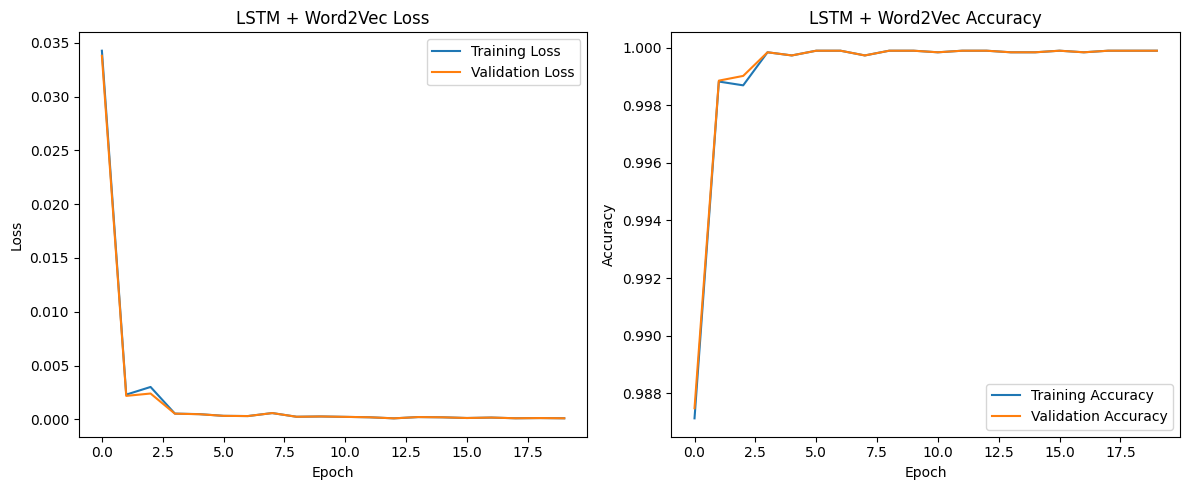

100%|██████████| 143/143 [00:00<00:00, 712.38it/s]

Accuracy: 0.9840402273721032
F1 Score: 0.9895460403837892
ROC AUC Score: 0.9939213381873584


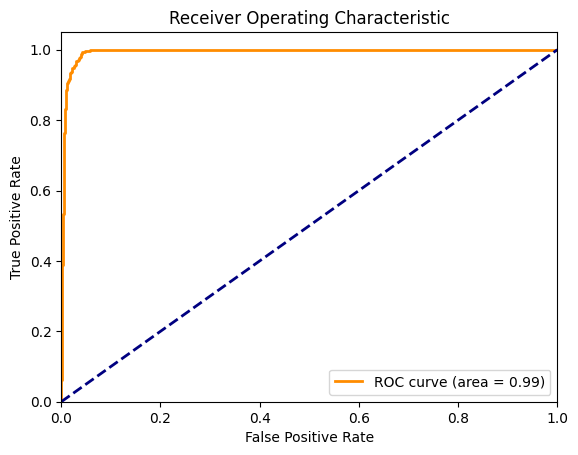


--- Model: GRU ---


  5%|▌         | 1/20 [00:02<00:55,  2.90s/it]

Epoch: 01, Train Loss: 0.018, Train Acc: 99.15%, Val Loss: 0.018, Val Acc: 99.19%


 10%|█         | 2/20 [00:05<00:52,  2.90s/it]

Epoch: 02, Train Loss: 0.005, Train Acc: 99.88%, Val Loss: 0.004, Val Acc: 99.90%


 15%|█▌        | 3/20 [00:08<00:49,  2.91s/it]

Epoch: 03, Train Loss: 0.001, Train Acc: 99.97%, Val Loss: 0.001, Val Acc: 99.98%


 20%|██        | 4/20 [00:11<00:46,  2.93s/it]

Epoch: 04, Train Loss: 0.001, Train Acc: 99.98%, Val Loss: 0.001, Val Acc: 99.98%


 25%|██▌       | 5/20 [00:14<00:43,  2.93s/it]

Epoch: 05, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 30%|███       | 6/20 [00:17<00:40,  2.92s/it]

Epoch: 06, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 35%|███▌      | 7/20 [00:20<00:37,  2.91s/it]

Epoch: 07, Train Loss: 0.001, Train Acc: 99.97%, Val Loss: 0.001, Val Acc: 99.97%


 40%|████      | 8/20 [00:23<00:34,  2.89s/it]

Epoch: 08, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 45%|████▌     | 9/20 [00:26<00:31,  2.91s/it]

Epoch: 09, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 50%|█████     | 10/20 [00:29<00:29,  2.93s/it]

Epoch: 10, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 55%|█████▌    | 11/20 [00:32<00:26,  2.92s/it]

Epoch: 11, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 60%|██████    | 12/20 [00:34<00:23,  2.91s/it]

Epoch: 12, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 65%|██████▌   | 13/20 [00:37<00:20,  2.90s/it]

Epoch: 13, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 70%|███████   | 14/20 [00:40<00:17,  2.91s/it]

Epoch: 14, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 75%|███████▌  | 15/20 [00:43<00:14,  2.94s/it]

Epoch: 15, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 80%|████████  | 16/20 [00:46<00:11,  2.91s/it]

Epoch: 16, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


 85%|████████▌ | 17/20 [00:49<00:08,  2.90s/it]

Epoch: 17, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 90%|█████████ | 18/20 [00:52<00:05,  2.88s/it]

Epoch: 18, Train Loss: 0.000, Train Acc: 99.99%, Val Loss: 0.000, Val Acc: 99.99%


 95%|█████████▌| 19/20 [00:55<00:02,  2.87s/it]

Epoch: 19, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


100%|██████████| 20/20 [00:58<00:00,  2.90s/it]

Epoch: 20, Train Loss: 0.000, Train Acc: 99.98%, Val Loss: 0.000, Val Acc: 99.98%


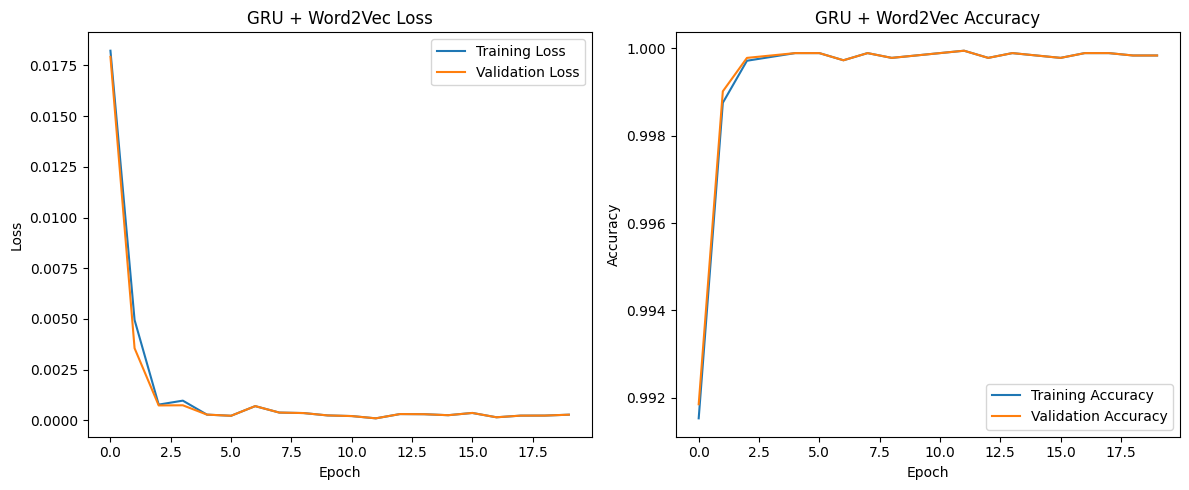

100%|██████████| 143/143 [00:00<00:00, 724.21it/s]

Accuracy: 0.9831657192829034
F1 Score: 0.9889921372408863
ROC AUC Score: 0.9848840864593836


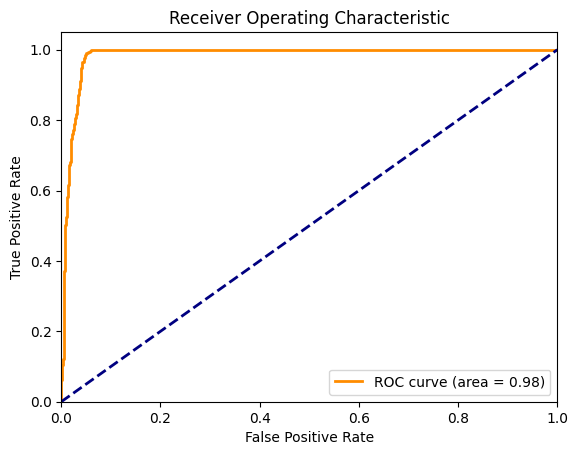


--- Model: FFNN ---


  5%|▌         | 1/20 [00:02<00:40,  2.15s/it]

Epoch: 01, Train Loss: 0.104, Train Acc: 92.87%, Val Loss: 0.104, Val Acc: 92.89%


 10%|█         | 2/20 [00:04<00:38,  2.15s/it]

Epoch: 02, Train Loss: 0.042, Train Acc: 97.41%, Val Loss: 0.042, Val Acc: 97.44%


 15%|█▌        | 3/20 [00:06<00:36,  2.16s/it]

Epoch: 03, Train Loss: 0.027, Train Acc: 98.27%, Val Loss: 0.027, Val Acc: 98.28%


 20%|██        | 4/20 [00:08<00:34,  2.19s/it]

Epoch: 04, Train Loss: 0.018, Train Acc: 98.84%, Val Loss: 0.018, Val Acc: 98.85%


 25%|██▌       | 5/20 [00:10<00:33,  2.20s/it]

Epoch: 05, Train Loss: 0.014, Train Acc: 99.08%, Val Loss: 0.014, Val Acc: 99.09%


 30%|███       | 6/20 [00:13<00:30,  2.20s/it]

Epoch: 06, Train Loss: 0.011, Train Acc: 99.25%, Val Loss: 0.011, Val Acc: 99.26%


 35%|███▌      | 7/20 [00:15<00:28,  2.21s/it]

Epoch: 07, Train Loss: 0.009, Train Acc: 99.49%, Val Loss: 0.008, Val Acc: 99.50%


 40%|████      | 8/20 [00:17<00:26,  2.22s/it]

Epoch: 08, Train Loss: 0.006, Train Acc: 99.57%, Val Loss: 0.006, Val Acc: 99.57%


 45%|████▌     | 9/20 [00:19<00:24,  2.19s/it]

Epoch: 09, Train Loss: 0.006, Train Acc: 99.67%, Val Loss: 0.006, Val Acc: 99.67%


 50%|█████     | 10/20 [00:21<00:21,  2.19s/it]

Epoch: 10, Train Loss: 0.005, Train Acc: 99.67%, Val Loss: 0.005, Val Acc: 99.67%


 55%|█████▌    | 11/20 [00:24<00:19,  2.18s/it]

Epoch: 11, Train Loss: 0.005, Train Acc: 99.69%, Val Loss: 0.005, Val Acc: 99.69%


 60%|██████    | 12/20 [00:26<00:17,  2.16s/it]

Epoch: 12, Train Loss: 0.003, Train Acc: 99.78%, Val Loss: 0.003, Val Acc: 99.79%


 65%|██████▌   | 13/20 [00:28<00:15,  2.16s/it]

Epoch: 13, Train Loss: 0.004, Train Acc: 99.80%, Val Loss: 0.004, Val Acc: 99.81%


 70%|███████   | 14/20 [00:30<00:12,  2.15s/it]

Epoch: 14, Train Loss: 0.002, Train Acc: 99.81%, Val Loss: 0.002, Val Acc: 99.81%


 75%|███████▌  | 15/20 [00:32<00:10,  2.15s/it]

Epoch: 15, Train Loss: 0.003, Train Acc: 99.81%, Val Loss: 0.003, Val Acc: 99.82%


 80%|████████  | 16/20 [00:34<00:08,  2.14s/it]

Epoch: 16, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.87%


 85%|████████▌ | 17/20 [00:36<00:06,  2.13s/it]

Epoch: 17, Train Loss: 0.002, Train Acc: 99.84%, Val Loss: 0.002, Val Acc: 99.84%


 90%|█████████ | 18/20 [00:38<00:04,  2.13s/it]

Epoch: 18, Train Loss: 0.002, Train Acc: 99.89%, Val Loss: 0.002, Val Acc: 99.89%


 95%|█████████▌| 19/20 [00:41<00:02,  2.12s/it]

Epoch: 19, Train Loss: 0.002, Train Acc: 99.90%, Val Loss: 0.002, Val Acc: 99.90%


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]

Epoch: 20, Train Loss: 0.002, Train Acc: 99.85%, Val Loss: 0.002, Val Acc: 99.85%


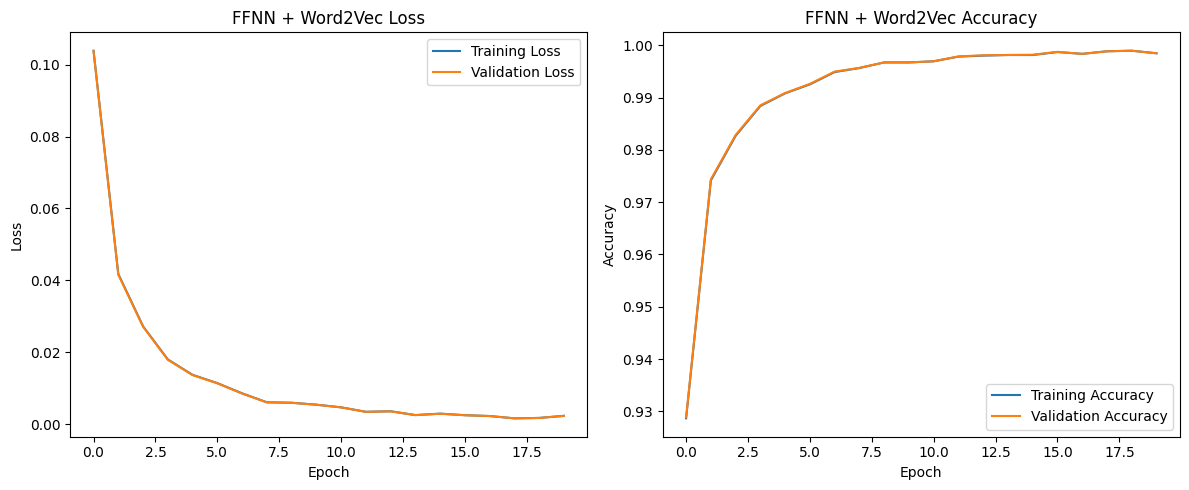

100%|██████████| 143/143 [00:00<00:00, 924.21it/s]


Accuracy: 0.9188893747267162
F1 Score: 0.9491432488005483
ROC AUC Score: 0.9944616115066999


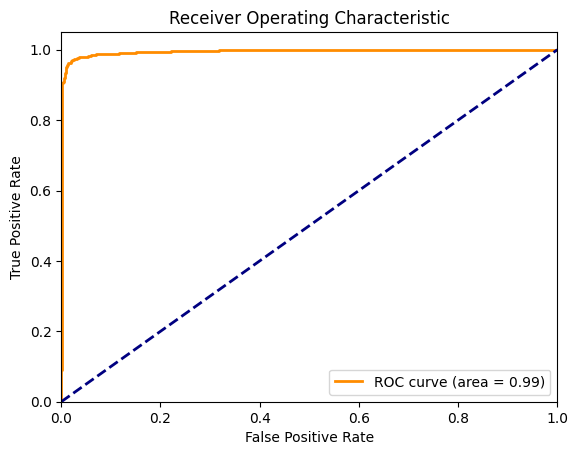

In [103]:
results = []

# Список эмбеддингов
embedding_methods = ['Custom', 'Word2Vec'] 

for embedding_method in embedding_methods:
    print(f"\n=== Embedding: {embedding_method} ===")
    
    # Собираем embedding_layer
    if embedding_method == 'Custom':
        embedding_layer = nn.Embedding(len(vocab), 128)  
    elif embedding_method == 'Word2Vec':
        # Создаем матрицу Word2Vec
        w2v_model = Word2Vec(sentences=df['tokens'], vector_size=128, window=5, min_count=1, workers=4, epochs=10)
        embedding_matrix = torch.zeros(len(vocab), 128)
        for word, idx in vocab.items():
            if word in w2v_model.wv:
                embedding_matrix[idx] = torch.tensor(w2v_model.wv[word])
        embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Можно freeze=True
        
    # Прогоним по моделям
    for model_type in ['RNN', 'LSTM', 'GRU', 'FFNN']:
        
        print(f"\n--- Model: {model_type} ---")
        
        # Параметры модели
        config = model_configs[model_type]
        hidden_dim = config['hidden_dim']
        dropout = config['dropout']
        n_epochs = config['n_epochs']
        n_layers = config.get('n_layers', None)
        
        # Модель
        model = BaseTextModel(embedding_layer, model_type, hidden_dim, OUTPUT_DIM, n_layers, dropout).to(device)
        
        # Оптимизатор, loss
        optimizer = optim.Adam(model.parameters())
        class_counts = df['label'].value_counts()
        pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        # Обучение
        train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_loader, optimizer, criterion, n_epochs
        )
        
        # Визуализация
        plot_training(train_losses, train_accuracies, val_losses, val_accuracies, f"{model_type} + {embedding_method}")

        # Оценка
        accuracy, f1, roc_auc = evaluate_model(model, test_loader)
        results.append({
            'Model': model_type,
            'Embedding': embedding_method,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
            })

In [105]:
df_results = pd.DataFrame(results)
df_results

,Model,Embedding,Accuracy,F1 Score,ROC AUC
0,RNN,Custom,0.317009,0.183481,0.874754
1,LSTM,Custom,0.893747,0.934484,0.993376
2,GRU,Custom,0.986882,0.991389,0.993673
3,FFNN,Custom,0.967862,0.978575,0.994473
4,RNN,Word2Vec,0.892436,0.923886,0.959010
5,LSTM,Word2Vec,0.984040,0.989546,0.993921
6,GRU,Word2Vec,0.983166,0.988992,0.984884
7,FFNN,Word2Vec,0.918889,0.949143,0.994462


In [107]:
# Подготовка BoW и TF-IDF векторов
def prepare_bow_tfidf_data(df, vectorizer_type='bow'):
    texts = df['text'].tolist()
    labels = df['label'].tolist()

    if vectorizer_type == 'bow':
        vectorizer = CountVectorizer()
    elif vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("vectorizer_type must be 'bow' or 'tfidf'")

    features = vectorizer.fit_transform(texts).toarray()
    return features, labels, vectorizer

# Dataset для BoW/TF-IDF
class BowTfidfDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# FFNN для BoW/TF-IDF
class FFNN_BOW_TFIDF(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

# Функция тренировки 
def train_ffnn_model(model, train_loader, optimizer, criterion, n_epochs=10):
    model.train()
    for epoch in tqdm(range(n_epochs)):
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(x_batch.to(device)).squeeze(1)
            loss = criterion(predictions, y_batch.to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}: Train Loss = {epoch_loss / len(train_loader):.4f}")

# Функция оценки
def evaluate_ffnn_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch.to(device)).squeeze(1)
            all_preds += preds.tolist()
            all_labels += y_batch.tolist()

    preds_tensor = torch.tensor(all_preds)
    labels_tensor = torch.tensor(all_labels)
    y_pred_binary = torch.round(torch.sigmoid(preds_tensor)).numpy()
    y_true = labels_tensor.numpy()
    acc = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, preds_tensor.numpy())
    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc:.4f}")
    return acc, f1, roc_auc

# Пайплайн для BoW и TF-IDF
results_bow_tfidf = []

for vectorizer_type in ['bow', 'tfidf']:
    print(f"\n=== {vectorizer_type.upper()} + FFNN ===")
    # Подготовка данных
    features, labels, vectorizer = prepare_bow_tfidf_data(df, vectorizer_type)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    train_dataset = BowTfidfDataset(X_train, y_train)
    test_dataset = BowTfidfDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Модель
    input_dim = X_train.shape[1]
    model = FFNN_BOW_TFIDF(input_dim, hidden_dim=128, output_dim=1, dropout=0.5).to(device)

    # Loss, optimizer
    class_counts = df['label'].value_counts()
    pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters())

    # Тренировка
    train_ffnn_model(model, train_loader, optimizer, criterion, n_epochs=20)

    # Оценка
    acc, f1, roc_auc = evaluate_ffnn_model(model, test_loader)

    # Сохраняем метрики
    results_bow_tfidf.append({
        'Model': 'FFNN',
        'Embedding': vectorizer_type.upper(),
        'Accuracy': acc,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Объединяем с основным df_results
df_bow_tfidf = pd.DataFrame(results_bow_tfidf)
display(df_bow_tfidf)


=== BOW + FFNN ===


  5%|▌         | 1/20 [00:02<00:48,  2.55s/it]

Epoch 1: Train Loss = 0.1012


 10%|█         | 2/20 [00:04<00:43,  2.40s/it]

Epoch 2: Train Loss = 0.0127


 15%|█▌        | 3/20 [00:07<00:40,  2.36s/it]

Epoch 3: Train Loss = 0.0040


 20%|██        | 4/20 [00:09<00:38,  2.38s/it]

Epoch 4: Train Loss = 0.0018


 25%|██▌       | 5/20 [00:11<00:35,  2.36s/it]

Epoch 5: Train Loss = 0.0008


 30%|███       | 6/20 [00:14<00:33,  2.37s/it]

Epoch 6: Train Loss = 0.0006


 35%|███▌      | 7/20 [00:16<00:30,  2.37s/it]

Epoch 7: Train Loss = 0.0006


 40%|████      | 8/20 [00:18<00:28,  2.35s/it]

Epoch 8: Train Loss = 0.0005


 45%|████▌     | 9/20 [00:21<00:25,  2.33s/it]

Epoch 9: Train Loss = 0.0006


 50%|█████     | 10/20 [00:23<00:23,  2.32s/it]

Epoch 10: Train Loss = 0.0004


 55%|█████▌    | 11/20 [00:26<00:21,  2.37s/it]

Epoch 11: Train Loss = 0.0005


 60%|██████    | 12/20 [00:28<00:18,  2.36s/it]

Epoch 12: Train Loss = 0.0006


 65%|██████▌   | 13/20 [00:30<00:16,  2.35s/it]

Epoch 13: Train Loss = 0.0007


 70%|███████   | 14/20 [00:33<00:14,  2.37s/it]

Epoch 14: Train Loss = 0.0003


 75%|███████▌  | 15/20 [00:35<00:11,  2.36s/it]

Epoch 15: Train Loss = 0.0006


 80%|████████  | 16/20 [00:37<00:09,  2.36s/it]

Epoch 16: Train Loss = 0.0004


 85%|████████▌ | 17/20 [00:40<00:07,  2.37s/it]

Epoch 17: Train Loss = 0.0005


 90%|█████████ | 18/20 [00:42<00:04,  2.41s/it]

Epoch 18: Train Loss = 0.0001


 95%|█████████▌| 19/20 [00:44<00:02,  2.37s/it]

Epoch 19: Train Loss = 0.0007


100%|██████████| 20/20 [00:47<00:00,  2.36s/it]

Epoch 20: Train Loss = 0.0005


Accuracy: 0.9869, F1: 0.9914, ROC AUC: 0.9966

=== TFIDF + FFNN ===


  5%|▌         | 1/20 [00:03<00:59,  3.15s/it]

Epoch 1: Train Loss = 0.2162


 10%|█         | 2/20 [00:05<00:47,  2.65s/it]

Epoch 2: Train Loss = 0.0867


 15%|█▌        | 3/20 [00:07<00:42,  2.51s/it]

Epoch 3: Train Loss = 0.0385


 20%|██        | 4/20 [00:10<00:39,  2.50s/it]

Epoch 4: Train Loss = 0.0183


 25%|██▌       | 5/20 [00:12<00:36,  2.46s/it]

Epoch 5: Train Loss = 0.0094


 30%|███       | 6/20 [00:15<00:34,  2.43s/it]

Epoch 6: Train Loss = 0.0056


 35%|███▌      | 7/20 [00:17<00:31,  2.39s/it]

Epoch 7: Train Loss = 0.0035


 40%|████      | 8/20 [00:19<00:28,  2.36s/it]

Epoch 8: Train Loss = 0.0023


 45%|████▌     | 9/20 [00:21<00:25,  2.34s/it]

Epoch 9: Train Loss = 0.0019


 50%|█████     | 10/20 [00:24<00:23,  2.34s/it]

Epoch 10: Train Loss = 0.0014


 55%|█████▌    | 11/20 [00:26<00:21,  2.38s/it]

Epoch 11: Train Loss = 0.0009


 60%|██████    | 12/20 [00:29<00:18,  2.35s/it]

Epoch 12: Train Loss = 0.0007


 65%|██████▌   | 13/20 [00:31<00:16,  2.34s/it]

Epoch 13: Train Loss = 0.0007


 70%|███████   | 14/20 [00:33<00:13,  2.33s/it]

Epoch 14: Train Loss = 0.0009


 75%|███████▌  | 15/20 [00:35<00:11,  2.32s/it]

Epoch 15: Train Loss = 0.0006


 80%|████████  | 16/20 [00:38<00:09,  2.31s/it]

Epoch 16: Train Loss = 0.0006


 85%|████████▌ | 17/20 [00:40<00:06,  2.32s/it]

Epoch 17: Train Loss = 0.0007


 90%|█████████ | 18/20 [00:42<00:04,  2.32s/it]

Epoch 18: Train Loss = 0.0005


 95%|█████████▌| 19/20 [00:45<00:02,  2.31s/it]

Epoch 19: Train Loss = 0.0006


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]

Epoch 20: Train Loss = 0.0004


Accuracy: 0.9565, F1: 0.9713, ROC AUC: 0.9864


,Model,Embedding,Accuracy,F1 Score,ROC AUC
0,FFNN,BOW,0.986882,0.991406,0.996641
1,FFNN,TFIDF,0.956493,0.971305,0.986407


In [119]:
# Функция тренировки модели
def train_model(model, train_loader, optimizer, criterion, n_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        all_predictions = []
        all_labels = []

        for batch in train_loader:
            optimizer.zero_grad()
            
            texts = batch[0].to(device).long()  # Для Embedding слой
            labels = batch[1].to(device)
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            all_predictions += predictions.tolist()
            all_labels += labels.tolist()

        all_predictions = torch.tensor(all_predictions).to(device)
        all_labels = torch.tensor(all_labels).to(device)
        val_acc = binary_accuracy(all_predictions, all_labels)
        val_loss = criterion(all_predictions, all_labels).item()

        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(epoch_acc / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc.item())

        print(f"Epoch: {epoch+1:02}, Train Loss: {epoch_loss/len(train_loader):.3f}, Train Acc: {epoch_acc/len(train_loader)*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Функция оценки модели
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            texts = batch[0].to(device).long()
            labels = batch[1].to(device)
            
            predictions = model(texts).squeeze(1)
            all_predictions += predictions.tolist()
            all_labels += labels.tolist()

    all_predictions = torch.tensor(all_predictions).to(device)
    all_labels = torch.tensor(all_labels).to(device)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    # Построение ROC-кривой
    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return accuracy, f1, roc_auc


=== Embedding: GloVe ===

--- Model: RNN ---


  5%|▌         | 1/20 [17:42<5:36:27, 1062.50s/it]

Epoch: 01, Train Loss: 0.336, Train Acc: 52.07%, Val Loss: 0.336, Val Acc: 52.08%


 10%|█         | 2/20 [34:55<5:13:28, 1044.91s/it]

Epoch: 02, Train Loss: 0.336, Train Acc: 49.17%, Val Loss: 0.336, Val Acc: 49.18%


 15%|█▌        | 3/20 [51:36<4:50:24, 1024.99s/it]

Epoch: 03, Train Loss: 0.335, Train Acc: 50.53%, Val Loss: 0.334, Val Acc: 50.52%


 20%|██        | 4/20 [1:08:13<4:30:25, 1014.09s/it]

Epoch: 04, Train Loss: 0.335, Train Acc: 51.09%, Val Loss: 0.335, Val Acc: 51.10%


 25%|██▌       | 5/20 [1:24:46<4:11:35, 1006.38s/it]

Epoch: 05, Train Loss: 0.335, Train Acc: 49.72%, Val Loss: 0.335, Val Acc: 49.73%


 30%|███       | 6/20 [1:41:21<3:53:52, 1002.35s/it]

Epoch: 06, Train Loss: 0.335, Train Acc: 48.74%, Val Loss: 0.335, Val Acc: 48.76%


 35%|███▌      | 7/20 [1:58:00<3:36:58, 1001.46s/it]

Epoch: 07, Train Loss: 0.334, Train Acc: 49.60%, Val Loss: 0.334, Val Acc: 49.61%


 40%|████      | 8/20 [2:14:33<3:19:45, 998.80s/it] 

Epoch: 08, Train Loss: 0.335, Train Acc: 49.68%, Val Loss: 0.335, Val Acc: 49.69%


 45%|████▌     | 9/20 [2:31:06<3:02:46, 996.94s/it]

Epoch: 09, Train Loss: 0.335, Train Acc: 49.73%, Val Loss: 0.335, Val Acc: 49.73%


 50%|█████     | 10/20 [2:47:39<2:45:57, 995.71s/it]

Epoch: 10, Train Loss: 0.335, Train Acc: 49.65%, Val Loss: 0.335, Val Acc: 49.62%


 55%|█████▌    | 11/20 [3:04:12<2:29:14, 994.98s/it]

Epoch: 11, Train Loss: 0.335, Train Acc: 49.54%, Val Loss: 0.335, Val Acc: 49.56%


 60%|██████    | 12/20 [3:20:45<2:12:35, 994.38s/it]

Epoch: 12, Train Loss: 0.335, Train Acc: 50.17%, Val Loss: 0.335, Val Acc: 50.17%


 65%|██████▌   | 13/20 [3:37:18<1:55:57, 993.94s/it]

Epoch: 13, Train Loss: 0.335, Train Acc: 49.18%, Val Loss: 0.335, Val Acc: 49.17%


 70%|███████   | 14/20 [3:53:51<1:39:21, 993.63s/it]

Epoch: 14, Train Loss: 0.335, Train Acc: 50.01%, Val Loss: 0.335, Val Acc: 50.03%


 75%|███████▌  | 15/20 [4:10:24<1:22:46, 993.40s/it]

Epoch: 15, Train Loss: 0.335, Train Acc: 48.86%, Val Loss: 0.335, Val Acc: 48.84%


 80%|████████  | 16/20 [4:26:57<1:06:12, 993.18s/it]

Epoch: 16, Train Loss: 0.334, Train Acc: 51.49%, Val Loss: 0.334, Val Acc: 51.48%


 85%|████████▌ | 17/20 [4:43:29<49:38, 993.00s/it]  

Epoch: 17, Train Loss: 0.335, Train Acc: 50.11%, Val Loss: 0.335, Val Acc: 50.10%


 90%|█████████ | 18/20 [5:00:02<33:05, 992.85s/it]

Epoch: 18, Train Loss: 0.334, Train Acc: 51.37%, Val Loss: 0.334, Val Acc: 51.36%


 95%|█████████▌| 19/20 [5:16:34<16:32, 992.60s/it]

Epoch: 19, Train Loss: 0.335, Train Acc: 50.68%, Val Loss: 0.335, Val Acc: 50.67%


100%|██████████| 20/20 [5:33:06<00:00, 999.34s/it]

Epoch: 20, Train Loss: 0.335, Train Acc: 50.39%, Val Loss: 0.335, Val Acc: 50.40%


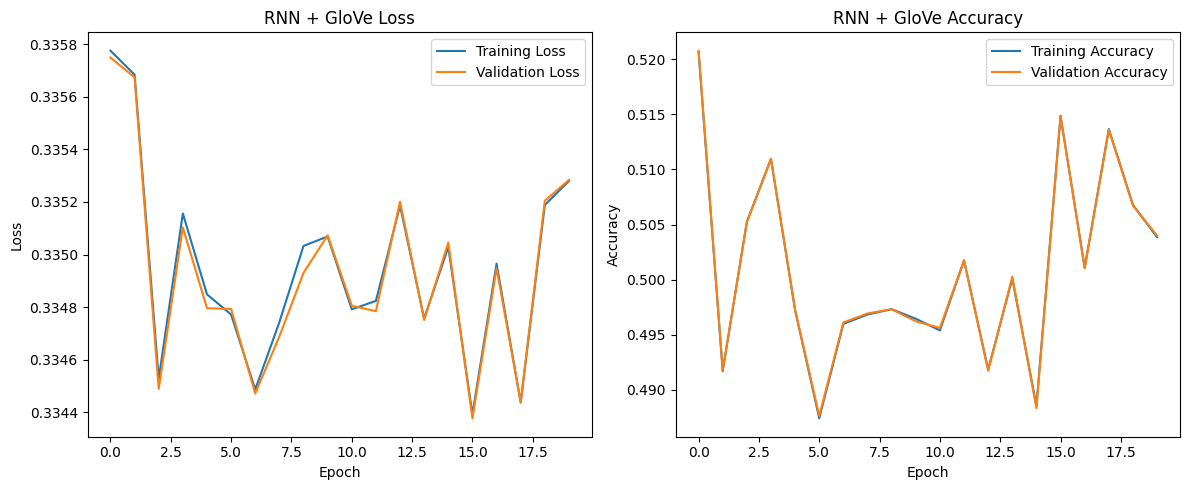

100%|██████████| 143/143 [00:41<00:00,  3.45it/s]


Accuracy: 0.24158285964145168
F1 Score: 0.0
ROC AUC Score: 0.5


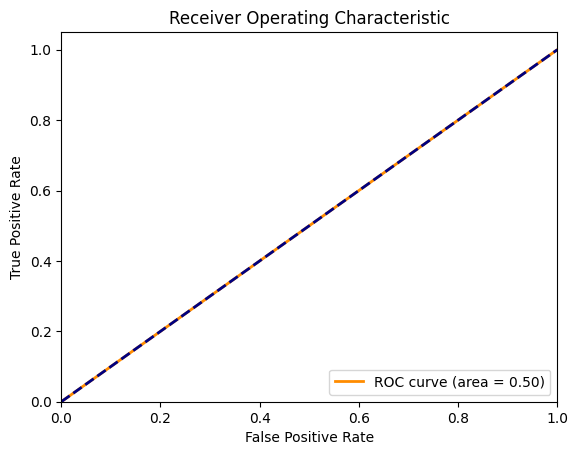


--- Model: LSTM ---


  5%|▌         | 1/20 [06:40<2:06:42, 400.11s/it]

Epoch: 01, Train Loss: 0.333, Train Acc: 52.59%, Val Loss: 0.333, Val Acc: 52.58%


 10%|█         | 2/20 [13:20<2:00:08, 400.47s/it]

Epoch: 02, Train Loss: 0.333, Train Acc: 52.66%, Val Loss: 0.333, Val Acc: 52.67%


 15%|█▌        | 3/20 [20:01<1:53:31, 400.67s/it]

Epoch: 03, Train Loss: 0.333, Train Acc: 49.23%, Val Loss: 0.333, Val Acc: 49.24%


 20%|██        | 4/20 [26:41<1:46:43, 400.20s/it]

Epoch: 04, Train Loss: 0.333, Train Acc: 48.24%, Val Loss: 0.333, Val Acc: 48.21%


 25%|██▌       | 5/20 [33:21<1:40:02, 400.18s/it]

Epoch: 05, Train Loss: 0.333, Train Acc: 54.07%, Val Loss: 0.333, Val Acc: 54.07%


 30%|███       | 6/20 [40:01<1:33:21, 400.13s/it]

Epoch: 06, Train Loss: 0.333, Train Acc: 53.88%, Val Loss: 0.333, Val Acc: 53.89%


 35%|███▌      | 7/20 [46:41<1:26:42, 400.17s/it]

Epoch: 07, Train Loss: 0.333, Train Acc: 52.54%, Val Loss: 0.333, Val Acc: 52.54%


 40%|████      | 8/20 [53:21<1:20:02, 400.20s/it]

Epoch: 08, Train Loss: 0.333, Train Acc: 52.68%, Val Loss: 0.333, Val Acc: 52.69%


 45%|████▌     | 9/20 [1:00:01<1:13:19, 399.98s/it]

Epoch: 09, Train Loss: 0.333, Train Acc: 55.49%, Val Loss: 0.333, Val Acc: 55.49%


 50%|█████     | 10/20 [1:06:40<1:06:38, 399.85s/it]

Epoch: 10, Train Loss: 0.333, Train Acc: 49.82%, Val Loss: 0.333, Val Acc: 49.83%


 55%|█████▌    | 11/20 [1:13:28<1:00:19, 402.20s/it]

Epoch: 11, Train Loss: 0.333, Train Acc: 50.01%, Val Loss: 0.333, Val Acc: 50.02%


 60%|██████    | 12/20 [1:20:17<53:55, 404.41s/it]  

Epoch: 12, Train Loss: 0.333, Train Acc: 52.36%, Val Loss: 0.333, Val Acc: 52.36%


 65%|██████▌   | 13/20 [1:26:57<46:59, 402.81s/it]

Epoch: 13, Train Loss: 0.333, Train Acc: 55.77%, Val Loss: 0.333, Val Acc: 55.79%


 70%|███████   | 14/20 [1:33:37<40:12, 402.05s/it]

Epoch: 14, Train Loss: 0.333, Train Acc: 53.24%, Val Loss: 0.333, Val Acc: 53.25%


 75%|███████▌  | 15/20 [1:40:16<33:26, 401.31s/it]

Epoch: 15, Train Loss: 0.333, Train Acc: 53.45%, Val Loss: 0.333, Val Acc: 53.46%


 80%|████████  | 16/20 [1:46:55<26:42, 400.60s/it]

Epoch: 16, Train Loss: 0.333, Train Acc: 46.64%, Val Loss: 0.333, Val Acc: 46.64%


 85%|████████▌ | 17/20 [1:53:35<20:00, 400.26s/it]

Epoch: 17, Train Loss: 0.333, Train Acc: 51.15%, Val Loss: 0.333, Val Acc: 51.14%


 90%|█████████ | 18/20 [2:00:15<13:20, 400.22s/it]

Epoch: 18, Train Loss: 0.333, Train Acc: 56.33%, Val Loss: 0.333, Val Acc: 56.34%


 95%|█████████▌| 19/20 [2:06:55<06:40, 400.15s/it]

Epoch: 19, Train Loss: 0.333, Train Acc: 43.57%, Val Loss: 0.333, Val Acc: 43.54%


100%|██████████| 20/20 [2:13:34<00:00, 400.74s/it]

Epoch: 20, Train Loss: 0.333, Train Acc: 61.09%, Val Loss: 0.333, Val Acc: 61.09%


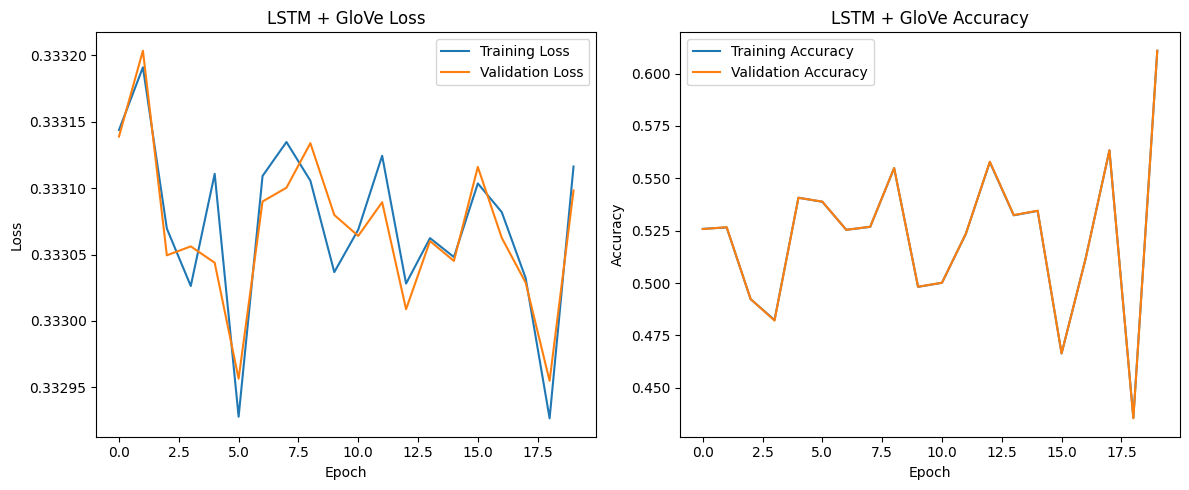

100%|██████████| 143/143 [00:52<00:00,  2.75it/s]

Accuracy: 0.24158285964145168
F1 Score: 0.0
ROC AUC Score: 0.5


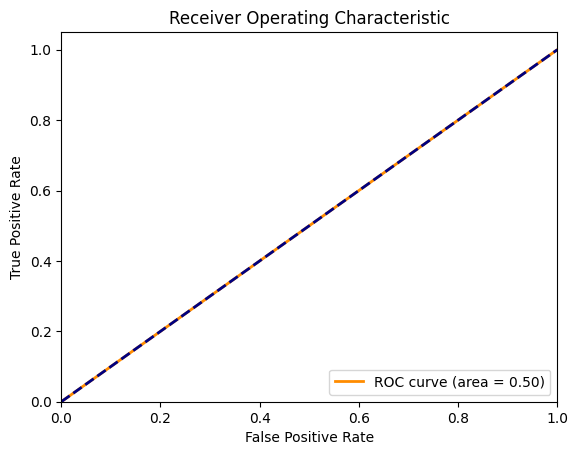


--- Model: GRU ---


  5%|▌         | 1/20 [07:29<2:22:11, 449.05s/it]

Epoch: 01, Train Loss: 0.333, Train Acc: 47.98%, Val Loss: 0.333, Val Acc: 47.97%


 10%|█         | 2/20 [14:57<2:14:38, 448.80s/it]

Epoch: 02, Train Loss: 0.333, Train Acc: 46.31%, Val Loss: 0.333, Val Acc: 46.28%


 15%|█▌        | 3/20 [22:26<2:07:12, 448.97s/it]

Epoch: 03, Train Loss: 0.333, Train Acc: 51.56%, Val Loss: 0.333, Val Acc: 51.57%


 20%|██        | 4/20 [29:56<1:59:48, 449.27s/it]

Epoch: 04, Train Loss: 0.333, Train Acc: 48.79%, Val Loss: 0.333, Val Acc: 48.79%


 25%|██▌       | 5/20 [37:25<1:52:19, 449.32s/it]

Epoch: 05, Train Loss: 0.333, Train Acc: 48.67%, Val Loss: 0.333, Val Acc: 48.67%


 30%|███       | 6/20 [44:54<1:44:46, 449.07s/it]

Epoch: 06, Train Loss: 0.333, Train Acc: 45.15%, Val Loss: 0.333, Val Acc: 45.14%


 35%|███▌      | 7/20 [52:23<1:37:15, 448.87s/it]

Epoch: 07, Train Loss: 0.333, Train Acc: 45.37%, Val Loss: 0.333, Val Acc: 45.38%


 40%|████      | 8/20 [59:52<1:29:47, 448.95s/it]

Epoch: 08, Train Loss: 0.333, Train Acc: 52.04%, Val Loss: 0.333, Val Acc: 52.06%


 45%|████▌     | 9/20 [1:07:21<1:22:20, 449.10s/it]

Epoch: 09, Train Loss: 0.333, Train Acc: 44.56%, Val Loss: 0.333, Val Acc: 44.55%


 50%|█████     | 10/20 [1:14:51<1:14:52, 449.23s/it]

Epoch: 10, Train Loss: 0.333, Train Acc: 41.35%, Val Loss: 0.333, Val Acc: 41.34%


 55%|█████▌    | 11/20 [1:22:19<1:07:21, 449.04s/it]

Epoch: 11, Train Loss: 0.333, Train Acc: 45.52%, Val Loss: 0.333, Val Acc: 45.50%


 60%|██████    | 12/20 [1:29:48<59:51, 448.89s/it]  

Epoch: 12, Train Loss: 0.333, Train Acc: 55.74%, Val Loss: 0.333, Val Acc: 55.76%


 65%|██████▌   | 13/20 [1:37:17<52:22, 448.88s/it]

Epoch: 13, Train Loss: 0.333, Train Acc: 54.96%, Val Loss: 0.333, Val Acc: 54.98%


 70%|███████   | 14/20 [1:44:46<44:54, 449.02s/it]

Epoch: 14, Train Loss: 0.333, Train Acc: 42.69%, Val Loss: 0.333, Val Acc: 42.67%


 75%|███████▌  | 15/20 [1:52:16<37:27, 449.42s/it]

Epoch: 15, Train Loss: 0.333, Train Acc: 49.61%, Val Loss: 0.333, Val Acc: 49.61%


 80%|████████  | 16/20 [1:59:46<29:57, 449.46s/it]

Epoch: 16, Train Loss: 0.333, Train Acc: 42.53%, Val Loss: 0.333, Val Acc: 42.52%


 85%|████████▌ | 17/20 [2:07:15<22:27, 449.30s/it]

Epoch: 17, Train Loss: 0.333, Train Acc: 55.01%, Val Loss: 0.333, Val Acc: 55.04%


 90%|█████████ | 18/20 [2:15:06<15:11, 455.93s/it]

Epoch: 18, Train Loss: 0.333, Train Acc: 45.42%, Val Loss: 0.333, Val Acc: 45.42%


 95%|█████████▌| 19/20 [2:23:07<07:43, 463.30s/it]

Epoch: 19, Train Loss: 0.333, Train Acc: 46.03%, Val Loss: 0.333, Val Acc: 46.03%


100%|██████████| 20/20 [2:30:44<00:00, 452.25s/it]

Epoch: 20, Train Loss: 0.333, Train Acc: 56.14%, Val Loss: 0.333, Val Acc: 56.16%


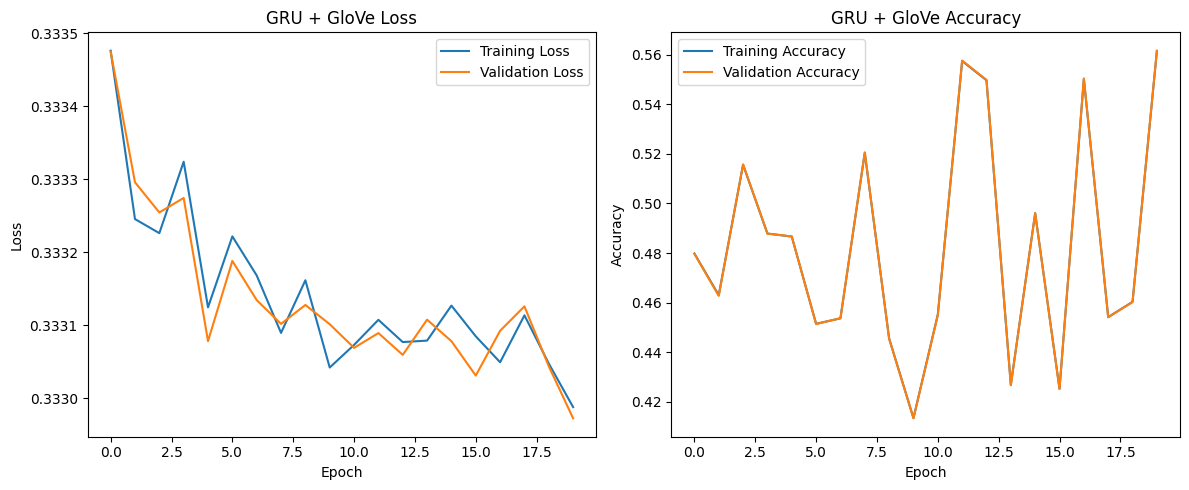

100%|██████████| 143/143 [01:03<00:00,  2.27it/s]

Accuracy: 0.24158285964145168
F1 Score: 0.0
ROC AUC Score: 0.5


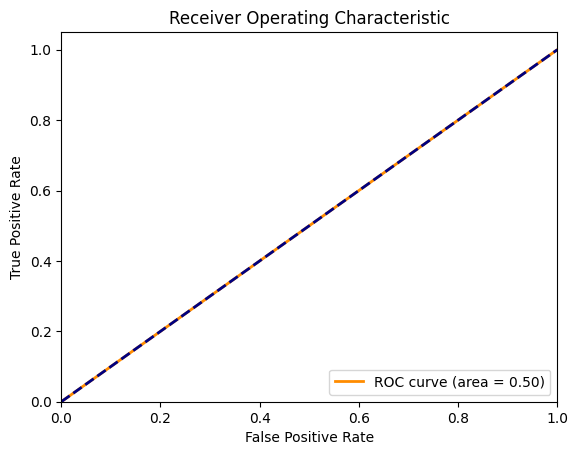


--- Model: FFNN ---


  5%|▌         | 1/20 [00:11<03:32, 11.17s/it]

Epoch: 01, Train Loss: 0.333, Train Acc: 54.46%, Val Loss: 0.333, Val Acc: 54.47%


 10%|█         | 2/20 [00:21<03:14, 10.79s/it]

Epoch: 02, Train Loss: 0.333, Train Acc: 49.77%, Val Loss: 0.333, Val Acc: 49.76%


 15%|█▌        | 3/20 [00:32<03:01, 10.67s/it]

Epoch: 03, Train Loss: 0.333, Train Acc: 50.58%, Val Loss: 0.333, Val Acc: 50.59%


 20%|██        | 4/20 [00:42<02:50, 10.66s/it]

Epoch: 04, Train Loss: 0.333, Train Acc: 45.80%, Val Loss: 0.333, Val Acc: 45.78%


 25%|██▌       | 5/20 [00:53<02:39, 10.65s/it]

Epoch: 05, Train Loss: 0.333, Train Acc: 52.18%, Val Loss: 0.333, Val Acc: 52.18%


 30%|███       | 6/20 [01:03<02:27, 10.55s/it]

Epoch: 06, Train Loss: 0.333, Train Acc: 48.16%, Val Loss: 0.333, Val Acc: 48.16%


 35%|███▌      | 7/20 [01:14<02:16, 10.48s/it]

Epoch: 07, Train Loss: 0.333, Train Acc: 43.57%, Val Loss: 0.333, Val Acc: 43.55%


 40%|████      | 8/20 [01:24<02:05, 10.44s/it]

Epoch: 08, Train Loss: 0.333, Train Acc: 45.76%, Val Loss: 0.333, Val Acc: 45.76%


 45%|████▌     | 9/20 [01:34<01:54, 10.41s/it]

Epoch: 09, Train Loss: 0.333, Train Acc: 50.80%, Val Loss: 0.333, Val Acc: 50.80%


 50%|█████     | 10/20 [01:45<01:43, 10.40s/it]

Epoch: 10, Train Loss: 0.333, Train Acc: 44.93%, Val Loss: 0.333, Val Acc: 44.94%


 55%|█████▌    | 11/20 [01:55<01:33, 10.38s/it]

Epoch: 11, Train Loss: 0.333, Train Acc: 56.15%, Val Loss: 0.333, Val Acc: 56.16%


 60%|██████    | 12/20 [02:05<01:23, 10.38s/it]

Epoch: 12, Train Loss: 0.333, Train Acc: 41.23%, Val Loss: 0.333, Val Acc: 41.21%


 65%|██████▌   | 13/20 [02:16<01:12, 10.38s/it]

Epoch: 13, Train Loss: 0.333, Train Acc: 53.71%, Val Loss: 0.333, Val Acc: 53.71%


 70%|███████   | 14/20 [02:26<01:02, 10.37s/it]

Epoch: 14, Train Loss: 0.333, Train Acc: 50.62%, Val Loss: 0.333, Val Acc: 50.62%


 75%|███████▌  | 15/20 [02:37<00:51, 10.36s/it]

Epoch: 15, Train Loss: 0.333, Train Acc: 38.12%, Val Loss: 0.333, Val Acc: 38.09%


 80%|████████  | 16/20 [02:47<00:41, 10.35s/it]

Epoch: 16, Train Loss: 0.333, Train Acc: 51.53%, Val Loss: 0.333, Val Acc: 51.53%


 85%|████████▌ | 17/20 [02:57<00:31, 10.35s/it]

Epoch: 17, Train Loss: 0.333, Train Acc: 61.50%, Val Loss: 0.333, Val Acc: 61.52%


 90%|█████████ | 18/20 [03:08<00:20, 10.35s/it]

Epoch: 18, Train Loss: 0.333, Train Acc: 50.93%, Val Loss: 0.333, Val Acc: 50.94%


 95%|█████████▌| 19/20 [03:18<00:10, 10.36s/it]

Epoch: 19, Train Loss: 0.333, Train Acc: 52.76%, Val Loss: 0.333, Val Acc: 52.76%


100%|██████████| 20/20 [03:28<00:00, 10.44s/it]

Epoch: 20, Train Loss: 0.333, Train Acc: 44.76%, Val Loss: 0.333, Val Acc: 44.75%


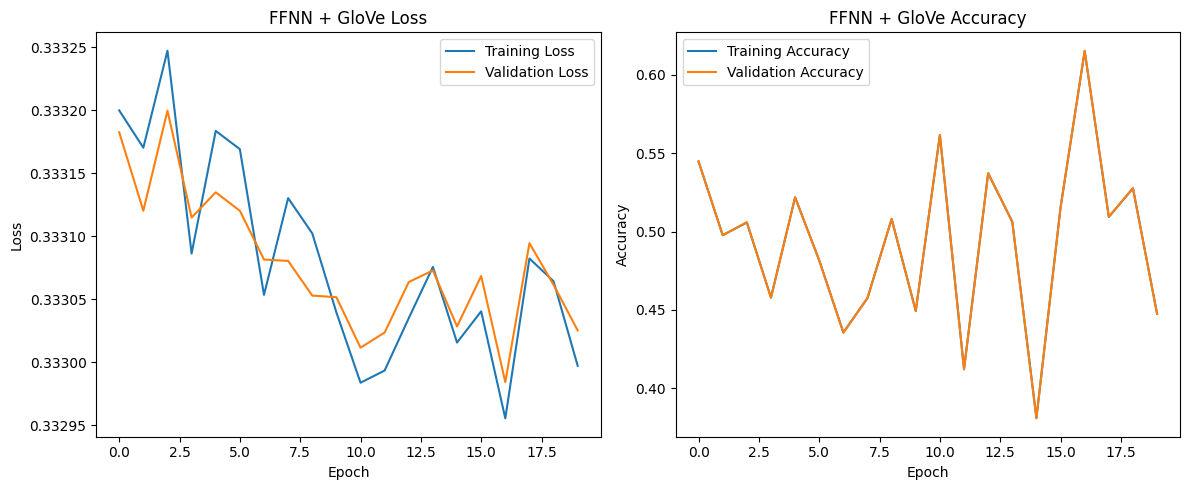

100%|██████████| 143/143 [00:00<00:00, 253.83it/s]


Accuracy: 0.7584171403585483
F1 Score: 0.8626134526917817
ROC AUC Score: 0.5


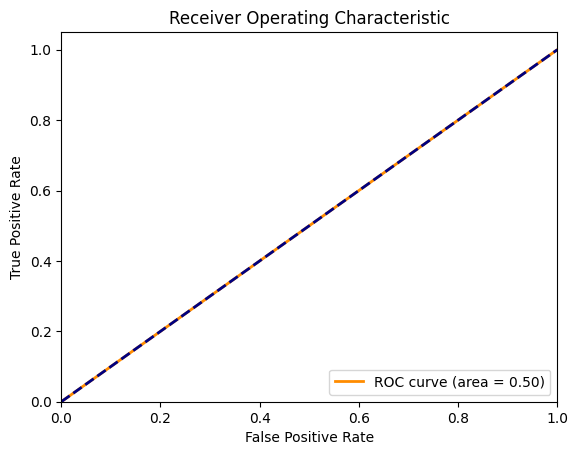


=== Embedding: FastText ===

--- Model: RNN ---


  5%|▌         | 1/20 [18:52<5:58:28, 1132.04s/it]

Epoch: 01, Train Loss: 0.336, Train Acc: 52.70%, Val Loss: 0.336, Val Acc: 52.68%


 10%|█         | 2/20 [37:39<5:38:45, 1129.20s/it]

Epoch: 02, Train Loss: 0.335, Train Acc: 48.86%, Val Loss: 0.335, Val Acc: 48.84%


 15%|█▌        | 3/20 [56:30<5:20:10, 1130.01s/it]

Epoch: 03, Train Loss: 0.335, Train Acc: 50.33%, Val Loss: 0.335, Val Acc: 50.32%


 20%|██        | 4/20 [1:15:42<5:03:40, 1138.79s/it]

Epoch: 04, Train Loss: 0.334, Train Acc: 50.96%, Val Loss: 0.334, Val Acc: 50.98%


 25%|██▌       | 5/20 [1:34:29<4:43:36, 1134.40s/it]

Epoch: 05, Train Loss: 0.335, Train Acc: 50.37%, Val Loss: 0.335, Val Acc: 50.36%


 30%|███       | 6/20 [1:53:15<4:24:03, 1131.65s/it]

Epoch: 06, Train Loss: 0.335, Train Acc: 50.88%, Val Loss: 0.335, Val Acc: 50.86%


 35%|███▌      | 7/20 [2:12:00<4:04:44, 1129.55s/it]

Epoch: 07, Train Loss: 0.335, Train Acc: 51.00%, Val Loss: 0.335, Val Acc: 51.02%


 40%|████      | 8/20 [2:30:53<3:46:07, 1130.60s/it]

Epoch: 08, Train Loss: 0.335, Train Acc: 50.65%, Val Loss: 0.335, Val Acc: 50.66%


 45%|████▌     | 9/20 [2:49:56<3:27:58, 1134.43s/it]

Epoch: 09, Train Loss: 0.335, Train Acc: 48.62%, Val Loss: 0.335, Val Acc: 48.62%


 50%|█████     | 10/20 [3:08:42<3:08:37, 1131.77s/it]

Epoch: 10, Train Loss: 0.334, Train Acc: 52.10%, Val Loss: 0.334, Val Acc: 52.12%


 55%|█████▌    | 11/20 [3:27:28<2:49:29, 1129.96s/it]

Epoch: 11, Train Loss: 0.335, Train Acc: 48.86%, Val Loss: 0.335, Val Acc: 48.88%


 60%|██████    | 12/20 [3:46:18<2:30:41, 1130.20s/it]

Epoch: 12, Train Loss: 0.335, Train Acc: 49.97%, Val Loss: 0.335, Val Acc: 49.96%


 65%|██████▌   | 13/20 [4:05:10<2:11:55, 1130.76s/it]

Epoch: 13, Train Loss: 0.334, Train Acc: 50.19%, Val Loss: 0.334, Val Acc: 50.19%


 70%|███████   | 14/20 [4:24:35<1:54:06, 1141.03s/it]

Epoch: 14, Train Loss: 0.335, Train Acc: 49.17%, Val Loss: 0.335, Val Acc: 49.17%


 75%|███████▌  | 15/20 [4:44:08<1:35:52, 1150.51s/it]

Epoch: 15, Train Loss: 0.335, Train Acc: 50.41%, Val Loss: 0.335, Val Acc: 50.42%


 80%|████████  | 16/20 [5:05:04<1:18:49, 1182.27s/it]

Epoch: 16, Train Loss: 0.335, Train Acc: 48.99%, Val Loss: 0.335, Val Acc: 48.98%


 85%|████████▌ | 17/20 [5:24:29<58:51, 1177.20s/it]  

Epoch: 17, Train Loss: 0.335, Train Acc: 50.67%, Val Loss: 0.335, Val Acc: 50.66%


 90%|█████████ | 18/20 [5:43:25<38:49, 1164.77s/it]

Epoch: 18, Train Loss: 0.335, Train Acc: 49.99%, Val Loss: 0.335, Val Acc: 50.01%


 95%|█████████▌| 19/20 [6:04:04<19:47, 1187.21s/it]

Epoch: 19, Train Loss: 0.334, Train Acc: 50.33%, Val Loss: 0.334, Val Acc: 50.32%


100%|██████████| 20/20 [6:23:59<00:00, 1151.99s/it]

Epoch: 20, Train Loss: 0.335, Train Acc: 48.87%, Val Loss: 0.335, Val Acc: 48.89%


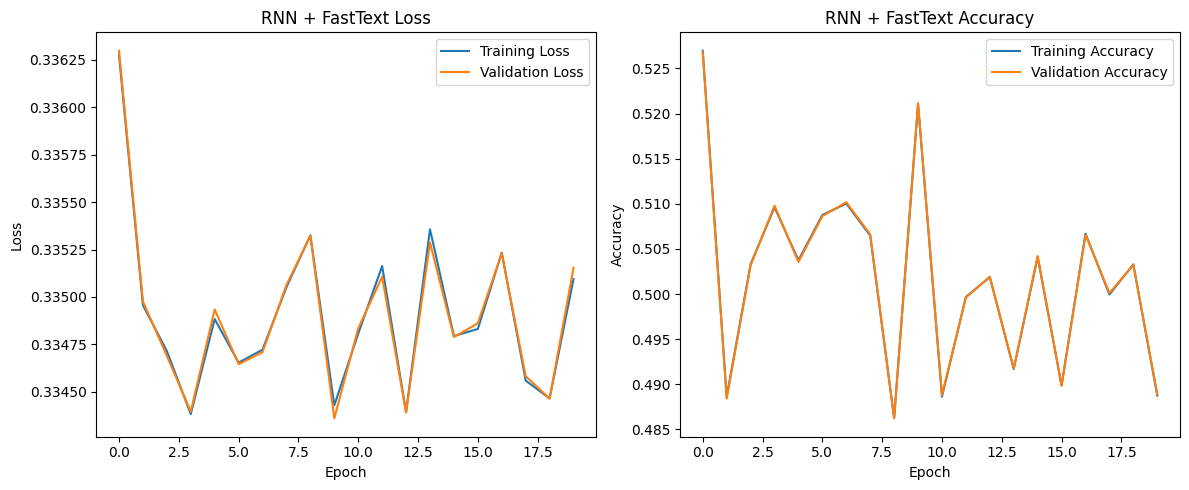

100%|██████████| 143/143 [00:59<00:00,  2.38it/s]

Accuracy: 0.24158285964145168
F1 Score: 0.0
ROC AUC Score: 0.5


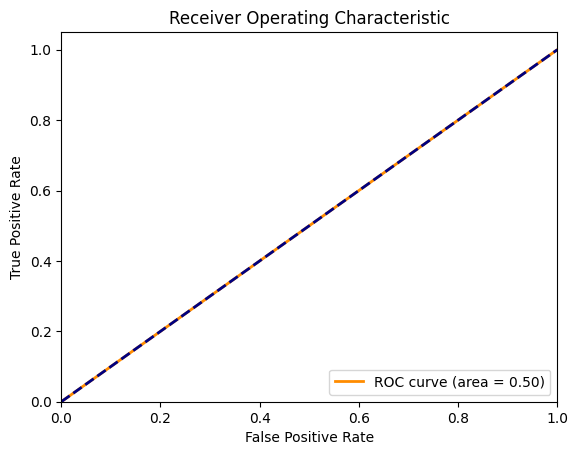


--- Model: LSTM ---


  5%|▌         | 1/20 [10:01<3:10:31, 601.66s/it]

Epoch: 01, Train Loss: 0.333, Train Acc: 48.14%, Val Loss: 0.333, Val Acc: 48.14%


 10%|█         | 2/20 [20:09<3:01:39, 605.53s/it]

Epoch: 02, Train Loss: 0.333, Train Acc: 49.80%, Val Loss: 0.333, Val Acc: 49.79%


 15%|█▌        | 3/20 [29:39<2:46:52, 588.98s/it]

Epoch: 03, Train Loss: 0.333, Train Acc: 53.43%, Val Loss: 0.333, Val Acc: 53.44%


 20%|██        | 4/20 [39:07<2:34:51, 580.71s/it]

Epoch: 04, Train Loss: 0.333, Train Acc: 46.14%, Val Loss: 0.333, Val Acc: 46.13%


 25%|██▌       | 5/20 [49:03<2:26:33, 586.26s/it]

Epoch: 05, Train Loss: 0.333, Train Acc: 48.85%, Val Loss: 0.333, Val Acc: 48.85%


 30%|███       | 6/20 [59:10<2:18:26, 593.35s/it]

Epoch: 06, Train Loss: 0.333, Train Acc: 54.69%, Val Loss: 0.333, Val Acc: 54.71%


 35%|███▌      | 7/20 [1:10:10<2:13:18, 615.30s/it]

Epoch: 07, Train Loss: 0.333, Train Acc: 46.78%, Val Loss: 0.333, Val Acc: 46.79%


 40%|████      | 8/20 [1:20:53<2:04:48, 624.03s/it]

Epoch: 08, Train Loss: 0.333, Train Acc: 45.46%, Val Loss: 0.333, Val Acc: 45.46%


 45%|████▌     | 9/20 [1:32:19<1:57:56, 643.33s/it]

Epoch: 09, Train Loss: 0.333, Train Acc: 49.74%, Val Loss: 0.333, Val Acc: 49.73%


 50%|█████     | 10/20 [1:43:48<1:49:33, 657.36s/it]

Epoch: 10, Train Loss: 0.333, Train Acc: 49.30%, Val Loss: 0.333, Val Acc: 49.32%


 55%|█████▌    | 11/20 [1:54:34<1:38:06, 654.00s/it]

Epoch: 11, Train Loss: 0.333, Train Acc: 45.92%, Val Loss: 0.333, Val Acc: 45.90%


 60%|██████    | 12/20 [2:05:27<1:27:08, 653.59s/it]

Epoch: 12, Train Loss: 0.333, Train Acc: 56.59%, Val Loss: 0.333, Val Acc: 56.58%


 65%|██████▌   | 13/20 [2:16:43<1:17:02, 660.42s/it]

Epoch: 13, Train Loss: 0.333, Train Acc: 51.32%, Val Loss: 0.333, Val Acc: 51.32%


 70%|███████   | 14/20 [2:29:26<1:09:08, 691.37s/it]

Epoch: 14, Train Loss: 0.333, Train Acc: 49.16%, Val Loss: 0.333, Val Acc: 49.17%


 75%|███████▌  | 15/20 [2:40:08<56:22, 676.48s/it]  

Epoch: 15, Train Loss: 0.333, Train Acc: 54.91%, Val Loss: 0.333, Val Acc: 54.91%


 80%|████████  | 16/20 [2:50:34<44:04, 661.22s/it]

Epoch: 16, Train Loss: 0.333, Train Acc: 50.96%, Val Loss: 0.333, Val Acc: 50.95%


 85%|████████▌ | 17/20 [3:01:11<32:41, 653.99s/it]

Epoch: 17, Train Loss: 0.333, Train Acc: 49.04%, Val Loss: 0.333, Val Acc: 49.05%


 90%|█████████ | 18/20 [3:11:45<21:36, 648.10s/it]

Epoch: 18, Train Loss: 0.333, Train Acc: 42.01%, Val Loss: 0.333, Val Acc: 42.00%


 95%|█████████▌| 19/20 [3:22:01<10:38, 638.44s/it]

Epoch: 19, Train Loss: 0.333, Train Acc: 52.91%, Val Loss: 0.333, Val Acc: 52.92%


100%|██████████| 20/20 [3:32:35<00:00, 637.80s/it]

Epoch: 20, Train Loss: 0.333, Train Acc: 45.96%, Val Loss: 0.333, Val Acc: 45.98%


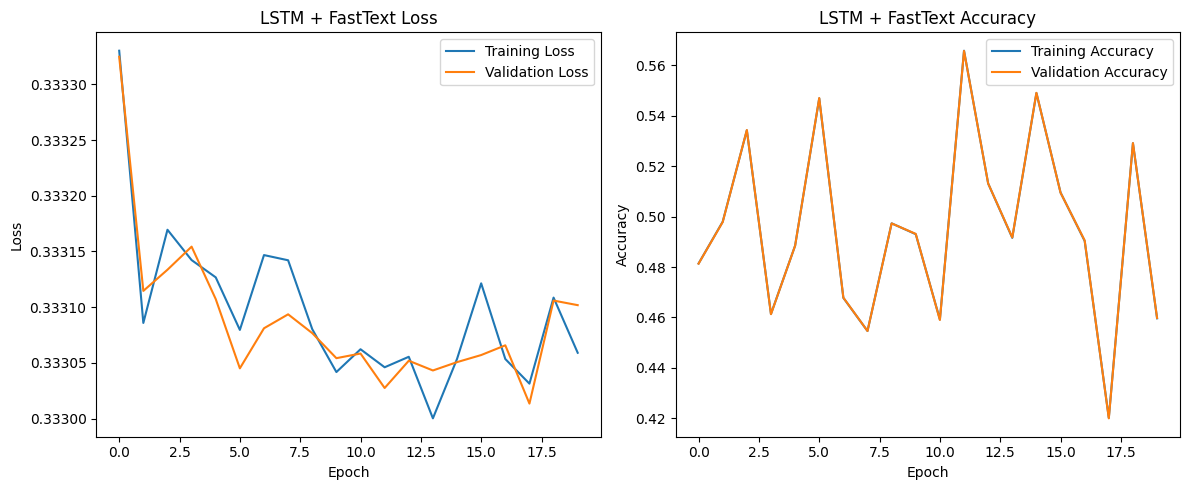

100%|██████████| 143/143 [01:03<00:00,  2.26it/s]


Accuracy: 0.24158285964145168
F1 Score: 0.0
ROC AUC Score: 0.5


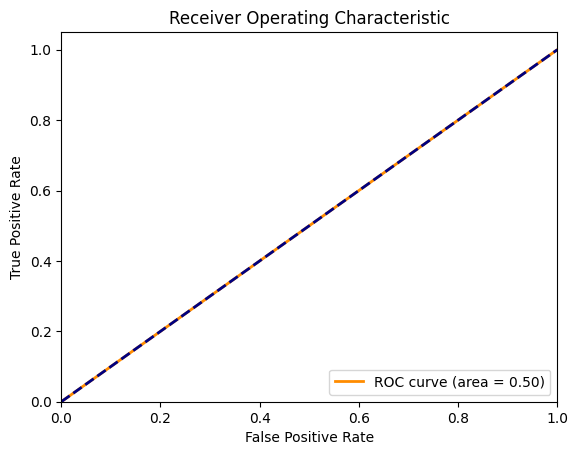


--- Model: GRU ---


  5%|▌         | 1/20 [18:14<5:46:39, 1094.73s/it]

Epoch: 01, Train Loss: 0.334, Train Acc: 53.87%, Val Loss: 0.334, Val Acc: 53.87%


 10%|█         | 2/20 [36:41<5:30:32, 1101.81s/it]

Epoch: 02, Train Loss: 0.333, Train Acc: 54.84%, Val Loss: 0.333, Val Acc: 54.84%


 15%|█▌        | 3/20 [56:12<5:21:08, 1133.45s/it]

Epoch: 03, Train Loss: 0.333, Train Acc: 52.35%, Val Loss: 0.333, Val Acc: 52.36%


 20%|██        | 4/20 [1:15:40<5:05:50, 1146.90s/it]

Epoch: 04, Train Loss: 0.333, Train Acc: 56.37%, Val Loss: 0.333, Val Acc: 56.39%


 25%|██▌       | 5/20 [1:33:20<4:38:53, 1115.55s/it]

Epoch: 05, Train Loss: 0.333, Train Acc: 55.68%, Val Loss: 0.333, Val Acc: 55.69%


 30%|███       | 6/20 [1:51:00<4:15:53, 1096.66s/it]

Epoch: 06, Train Loss: 0.333, Train Acc: 58.95%, Val Loss: 0.333, Val Acc: 58.96%


 35%|███▌      | 7/20 [2:08:34<3:54:36, 1082.77s/it]

Epoch: 07, Train Loss: 0.333, Train Acc: 53.70%, Val Loss: 0.333, Val Acc: 53.71%


 40%|████      | 8/20 [2:26:21<3:35:35, 1077.92s/it]

Epoch: 08, Train Loss: 0.333, Train Acc: 56.94%, Val Loss: 0.333, Val Acc: 56.96%


 45%|████▌     | 9/20 [2:43:58<3:16:22, 1071.16s/it]

Epoch: 09, Train Loss: 0.333, Train Acc: 52.70%, Val Loss: 0.333, Val Acc: 52.71%


 50%|█████     | 10/20 [3:01:33<2:57:41, 1066.15s/it]

Epoch: 10, Train Loss: 0.333, Train Acc: 52.23%, Val Loss: 0.333, Val Acc: 52.25%


 55%|█████▌    | 11/20 [3:19:09<2:39:28, 1063.15s/it]

Epoch: 11, Train Loss: 0.333, Train Acc: 51.46%, Val Loss: 0.333, Val Acc: 51.44%


 60%|██████    | 12/20 [3:36:46<2:21:29, 1061.25s/it]

Epoch: 12, Train Loss: 0.333, Train Acc: 53.14%, Val Loss: 0.333, Val Acc: 53.13%


 65%|██████▌   | 13/20 [3:54:21<2:03:36, 1059.54s/it]

Epoch: 13, Train Loss: 0.333, Train Acc: 59.41%, Val Loss: 0.333, Val Acc: 59.41%


 70%|███████   | 14/20 [4:11:57<1:45:51, 1058.51s/it]

Epoch: 14, Train Loss: 0.333, Train Acc: 48.04%, Val Loss: 0.333, Val Acc: 48.02%


 75%|███████▌  | 15/20 [4:29:34<1:28:08, 1057.79s/it]

Epoch: 15, Train Loss: 0.333, Train Acc: 53.68%, Val Loss: 0.333, Val Acc: 53.66%


 80%|████████  | 16/20 [4:47:09<1:10:28, 1057.15s/it]

Epoch: 16, Train Loss: 0.333, Train Acc: 49.79%, Val Loss: 0.333, Val Acc: 49.79%


 85%|████████▌ | 17/20 [5:04:45<52:50, 1056.67s/it]  

Epoch: 17, Train Loss: 0.333, Train Acc: 51.36%, Val Loss: 0.333, Val Acc: 51.36%


 90%|█████████ | 18/20 [5:22:20<35:12, 1056.21s/it]

Epoch: 18, Train Loss: 0.333, Train Acc: 52.02%, Val Loss: 0.333, Val Acc: 52.01%


 95%|█████████▌| 19/20 [5:39:57<17:36, 1056.37s/it]

Epoch: 19, Train Loss: 0.333, Train Acc: 54.22%, Val Loss: 0.333, Val Acc: 54.20%


100%|██████████| 20/20 [5:57:32<00:00, 1072.62s/it]

Epoch: 20, Train Loss: 0.333, Train Acc: 57.61%, Val Loss: 0.333, Val Acc: 57.63%


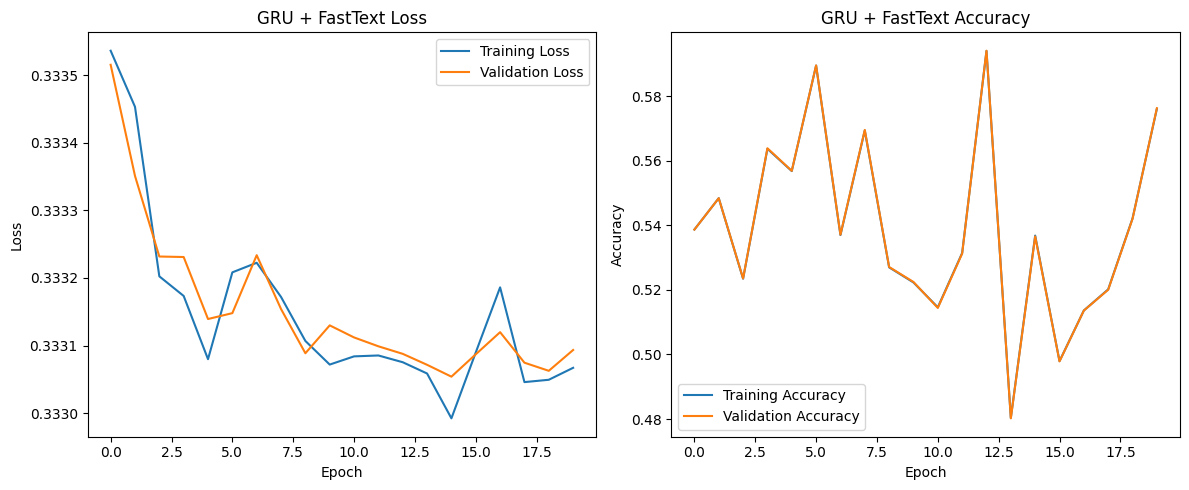

100%|██████████| 143/143 [01:19<00:00,  1.80it/s]


Accuracy: 0.24158285964145168
F1 Score: 0.0
ROC AUC Score: 0.5


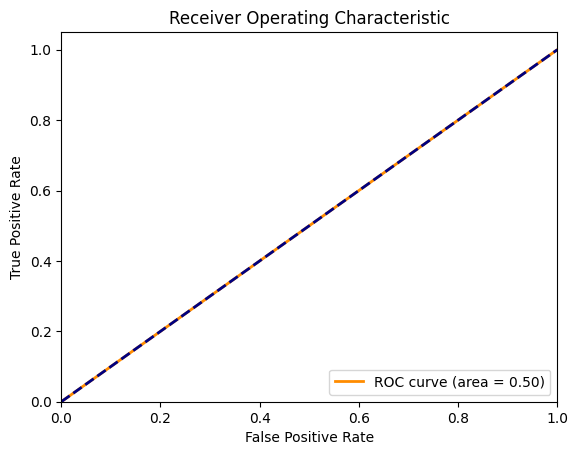


--- Model: FFNN ---


  5%|▌         | 1/20 [01:37<30:55, 97.68s/it]

Epoch: 01, Train Loss: 0.333, Train Acc: 46.75%, Val Loss: 0.333, Val Acc: 46.76%


 10%|█         | 2/20 [03:15<29:17, 97.61s/it]

Epoch: 02, Train Loss: 0.333, Train Acc: 47.43%, Val Loss: 0.333, Val Acc: 47.43%


 15%|█▌        | 3/20 [04:52<27:38, 97.57s/it]

Epoch: 03, Train Loss: 0.333, Train Acc: 48.67%, Val Loss: 0.333, Val Acc: 48.67%


 20%|██        | 4/20 [06:30<26:00, 97.54s/it]

Epoch: 04, Train Loss: 0.333, Train Acc: 51.41%, Val Loss: 0.333, Val Acc: 51.42%


 25%|██▌       | 5/20 [08:07<24:22, 97.51s/it]

Epoch: 05, Train Loss: 0.333, Train Acc: 51.11%, Val Loss: 0.333, Val Acc: 51.13%


 30%|███       | 6/20 [09:45<22:44, 97.49s/it]

Epoch: 06, Train Loss: 0.333, Train Acc: 46.90%, Val Loss: 0.333, Val Acc: 46.89%


 35%|███▌      | 7/20 [11:22<21:07, 97.48s/it]

Epoch: 07, Train Loss: 0.333, Train Acc: 43.89%, Val Loss: 0.333, Val Acc: 43.89%


 40%|████      | 8/20 [13:00<19:30, 97.54s/it]

Epoch: 08, Train Loss: 0.333, Train Acc: 50.76%, Val Loss: 0.333, Val Acc: 50.75%


 45%|████▌     | 9/20 [14:38<17:53, 97.60s/it]

Epoch: 09, Train Loss: 0.333, Train Acc: 55.79%, Val Loss: 0.333, Val Acc: 55.78%


 50%|█████     | 10/20 [16:15<16:16, 97.65s/it]

Epoch: 10, Train Loss: 0.333, Train Acc: 45.96%, Val Loss: 0.333, Val Acc: 45.98%


 55%|█████▌    | 11/20 [17:53<14:39, 97.68s/it]

Epoch: 11, Train Loss: 0.333, Train Acc: 44.54%, Val Loss: 0.333, Val Acc: 44.56%


 60%|██████    | 12/20 [19:31<13:01, 97.69s/it]

Epoch: 12, Train Loss: 0.333, Train Acc: 39.30%, Val Loss: 0.333, Val Acc: 39.30%


 65%|██████▌   | 13/20 [21:08<11:23, 97.70s/it]

Epoch: 13, Train Loss: 0.333, Train Acc: 45.11%, Val Loss: 0.333, Val Acc: 45.10%


 70%|███████   | 14/20 [22:46<09:46, 97.69s/it]

Epoch: 14, Train Loss: 0.333, Train Acc: 56.51%, Val Loss: 0.333, Val Acc: 56.52%


 75%|███████▌  | 15/20 [24:24<08:08, 97.66s/it]

Epoch: 15, Train Loss: 0.333, Train Acc: 44.79%, Val Loss: 0.333, Val Acc: 44.78%


 80%|████████  | 16/20 [26:01<06:30, 97.64s/it]

Epoch: 16, Train Loss: 0.333, Train Acc: 55.50%, Val Loss: 0.333, Val Acc: 55.51%


 85%|████████▌ | 17/20 [27:39<04:52, 97.63s/it]

Epoch: 17, Train Loss: 0.333, Train Acc: 40.21%, Val Loss: 0.333, Val Acc: 40.20%


 90%|█████████ | 18/20 [29:17<03:15, 97.63s/it]

Epoch: 18, Train Loss: 0.333, Train Acc: 33.90%, Val Loss: 0.333, Val Acc: 33.88%


 95%|█████████▌| 19/20 [30:54<01:37, 97.63s/it]

Epoch: 19, Train Loss: 0.333, Train Acc: 52.60%, Val Loss: 0.333, Val Acc: 52.60%


100%|██████████| 20/20 [32:32<00:00, 97.61s/it]

Epoch: 20, Train Loss: 0.333, Train Acc: 38.26%, Val Loss: 0.333, Val Acc: 38.26%


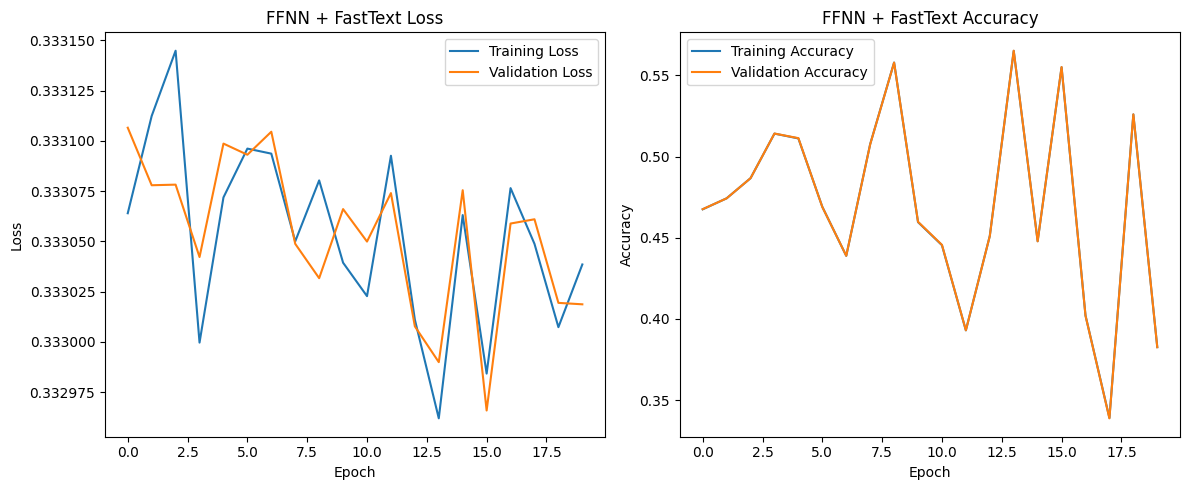

100%|██████████| 143/143 [00:00<00:00, 155.93it/s]

Accuracy: 0.7584171403585483
F1 Score: 0.8626134526917817
ROC AUC Score: 0.5


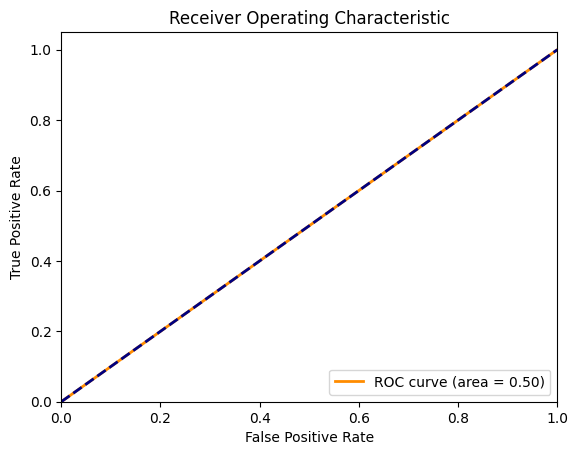

,Model,Embedding,Accuracy,F1 Score,ROC AUC
0,RNN,GloVe,0.241583,0.000000,0.5
1,LSTM,GloVe,0.241583,0.000000,0.5
2,GRU,GloVe,0.241583,0.000000,0.5
3,FFNN,GloVe,0.758417,0.862613,0.5
4,RNN,FastText,0.241583,0.000000,0.5
5,LSTM,FastText,0.241583,0.000000,0.5
6,GRU,FastText,0.241583,0.000000,0.5
7,FFNN,FastText,0.758417,0.862613,0.5


In [121]:
results_glove_fasttext = []

# Загрузка GloVe 
def load_glove_embeddings(glove_file_path, vocab, embedding_dim=128):
    embeddings = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if len(vector) == embedding_dim:
                embeddings[word] = vector
    embedding_matrix = torch.zeros(len(vocab), embedding_dim)
    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = torch.tensor(embeddings[word])
    return embedding_matrix

# Прогоним GloVe и FastText
for embedding_method in ['GloVe', 'FastText']:
    print(f"\n=== Embedding: {embedding_method} ===")
    
    if embedding_method == 'GloVe':
        glove_path = r'C:\Users\555\Desktop\LS\MLA\NLP\practice\glove.6B.50d.txt'
        embedding_matrix = load_glove_embeddings(glove_path, vocab, embedding_dim=50)
        embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
    elif embedding_method == 'FastText':
        ft_model = FastText(sentences=df['tokens'], vector_size=128, window=5, min_count=1, workers=4, epochs=10)
        embedding_matrix = torch.zeros(len(vocab), 128)
        for word, idx in vocab.items():
            if word in ft_model.wv:
                embedding_matrix[idx] = torch.tensor(ft_model.wv[word])
        embedding_layer = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
    
    # Прогоним по моделям
    for model_type in ['RNN', 'LSTM', 'GRU', 'FFNN']:
        print(f"\n--- Model: {model_type} ---")
        
        config = model_configs[model_type]
        hidden_dim = config['hidden_dim']
        dropout = config['dropout']
        n_epochs = config['n_epochs']
        n_layers = config.get('n_layers', None)
        
        model = BaseTextModel(embedding_layer, model_type, hidden_dim, OUTPUT_DIM, n_layers, dropout).to(device)
        
        optimizer = optim.Adam(model.parameters())
        class_counts = df['label'].value_counts()
        pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        train_losses, train_accuracies, val_losses, val_accuracies = train_model(
            model, train_loader, optimizer, criterion, n_epochs
        )
        
        plot_training(train_losses, train_accuracies, val_losses, val_accuracies, f"{model_type} + {embedding_method}")
        
        accuracy, f1, roc_auc = evaluate_model(model, test_loader)
        results_glove_fasttext.append({
            'Model': model_type,
            'Embedding': embedding_method,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })

df_glove_fasttext = pd.DataFrame(results_glove_fasttext)
display(df_glove_fasttext)

In [125]:
# Скачиваем словари для лемматизации
nltk.download('wordnet')
nltk.download('omw-1.4')

# 1. Лемматизация токенов
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

# Создаем новую колонку с лемматизированными токенами
df['tokens_lemmatized'] = df['tokens'].apply(lemmatize_tokens)

# 2. Пересобираем vocab
all_lemmas = [token for tokens in df['tokens_lemmatized'] for token in tokens]
vocab_counter_lemma = Counter(all_lemmas)

vocab_lemma = {word: idx + 2 for idx, (word, count) in enumerate(vocab_counter_lemma.items())}
vocab_lemma['<PAD>'] = 0
vocab_lemma['<UNK>'] = 1

# 3. Пересчитываем индексы
def tokens_to_indices(tokens, vocab):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

df['indices_lemma'] = df['tokens_lemmatized'].apply(lambda x: tokens_to_indices(x, vocab_lemma))

# 4. Разделяем на train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(df['indices_lemma'], df['label'], test_size=0.2, random_state=42)

train_dataset = TextDataset(list(train_texts), list(train_labels))
test_dataset = TextDataset(list(test_texts), list(test_labels))

train_lengths = [len(seq) for seq in train_texts]

batch_size = 32
train_sampler = BucketBatchSampler(train_lengths, batch_size=batch_size)

train_loader_lemma = DataLoader(train_dataset, batch_sampler=train_sampler, collate_fn=lambda x: collate_fn_custom(x, vocab_lemma))
test_loader_lemma = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: collate_fn_custom(x, vocab_lemma))

# 5. Обновим функцию collate_fn (чтобы она принимала конкретный vocab)
def collate_fn_custom(batch, vocab):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab['<PAD>'])
    labels = torch.stack(labels)
    return texts_padded, labels

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\555\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\555\AppData\Roaming\nltk_data...



--- Model: RNN + Custom + Lemmatization ---


  5%|▌         | 1/20 [00:03<00:59,  3.15s/it]

Epoch: 01, Train Loss: 0.076, Train Acc: 97.09%, Val Loss: 0.075, Val Acc: 97.12%


 10%|█         | 2/20 [00:05<00:50,  2.80s/it]

Epoch: 02, Train Loss: 0.061, Train Acc: 97.73%, Val Loss: 0.060, Val Acc: 97.75%


 15%|█▌        | 3/20 [00:08<00:45,  2.68s/it]

Epoch: 03, Train Loss: 0.051, Train Acc: 97.78%, Val Loss: 0.050, Val Acc: 97.81%


 20%|██        | 4/20 [00:11<00:43,  2.73s/it]

Epoch: 04, Train Loss: 0.043, Train Acc: 97.79%, Val Loss: 0.041, Val Acc: 97.81%


 25%|██▌       | 5/20 [00:13<00:41,  2.75s/it]

Epoch: 05, Train Loss: 0.037, Train Acc: 98.00%, Val Loss: 0.035, Val Acc: 98.03%


 30%|███       | 6/20 [00:16<00:38,  2.76s/it]

Epoch: 06, Train Loss: 0.031, Train Acc: 98.11%, Val Loss: 0.030, Val Acc: 98.14%


 35%|███▌      | 7/20 [00:19<00:35,  2.72s/it]

Epoch: 07, Train Loss: 0.023, Train Acc: 98.44%, Val Loss: 0.022, Val Acc: 98.47%


 40%|████      | 8/20 [00:21<00:32,  2.68s/it]

Epoch: 08, Train Loss: 0.018, Train Acc: 98.61%, Val Loss: 0.017, Val Acc: 98.64%


 45%|████▌     | 9/20 [00:24<00:29,  2.65s/it]

Epoch: 09, Train Loss: 0.016, Train Acc: 98.93%, Val Loss: 0.016, Val Acc: 98.95%


 50%|█████     | 10/20 [00:27<00:26,  2.63s/it]

Epoch: 10, Train Loss: 0.014, Train Acc: 99.08%, Val Loss: 0.013, Val Acc: 99.10%


 55%|█████▌    | 11/20 [00:29<00:23,  2.64s/it]

Epoch: 11, Train Loss: 0.014, Train Acc: 99.20%, Val Loss: 0.013, Val Acc: 99.22%


 60%|██████    | 12/20 [00:32<00:20,  2.62s/it]

Epoch: 12, Train Loss: 0.012, Train Acc: 99.34%, Val Loss: 0.012, Val Acc: 99.36%


 65%|██████▌   | 13/20 [00:35<00:18,  2.67s/it]

Epoch: 13, Train Loss: 0.019, Train Acc: 98.64%, Val Loss: 0.019, Val Acc: 98.66%


 70%|███████   | 14/20 [00:37<00:15,  2.65s/it]

Epoch: 14, Train Loss: 0.011, Train Acc: 99.28%, Val Loss: 0.011, Val Acc: 99.32%


 75%|███████▌  | 15/20 [00:40<00:13,  2.63s/it]

Epoch: 15, Train Loss: 0.009, Train Acc: 99.39%, Val Loss: 0.009, Val Acc: 99.42%


 80%|████████  | 16/20 [00:42<00:10,  2.62s/it]

Epoch: 16, Train Loss: 0.007, Train Acc: 99.45%, Val Loss: 0.007, Val Acc: 99.48%


 85%|████████▌ | 17/20 [00:45<00:07,  2.61s/it]

Epoch: 17, Train Loss: 0.005, Train Acc: 99.71%, Val Loss: 0.005, Val Acc: 99.74%


 90%|█████████ | 18/20 [00:48<00:05,  2.67s/it]

Epoch: 18, Train Loss: 0.008, Train Acc: 99.64%, Val Loss: 0.007, Val Acc: 99.66%


 95%|█████████▌| 19/20 [00:50<00:02,  2.69s/it]

Epoch: 19, Train Loss: 0.005, Train Acc: 99.65%, Val Loss: 0.004, Val Acc: 99.67%


100%|██████████| 20/20 [00:53<00:00,  2.68s/it]

Epoch: 20, Train Loss: 0.007, Train Acc: 99.50%, Val Loss: 0.007, Val Acc: 99.52%


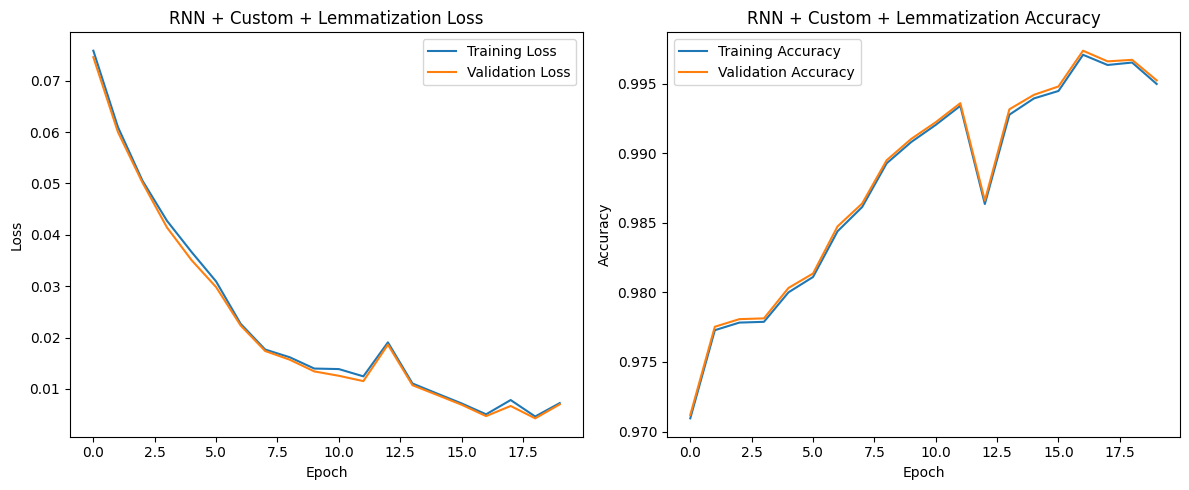

100%|██████████| 143/143 [00:00<00:00, 626.71it/s]


Accuracy: 0.780061215566244
F1 Score: 0.8728513650151668
ROC AUC Score: 0.560793792204777


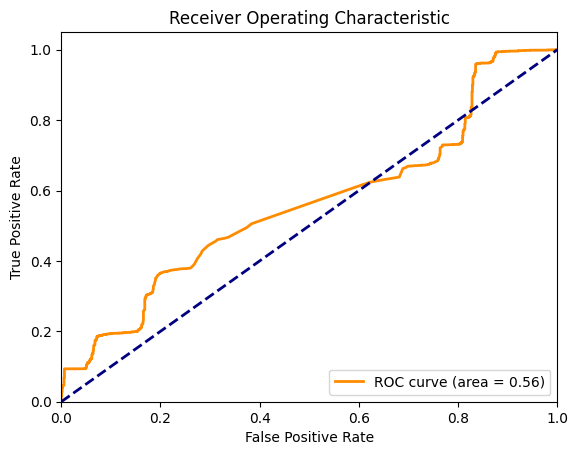


--- Model: LSTM + Custom + Lemmatization ---


  5%|▌         | 1/20 [00:02<00:53,  2.82s/it]

Epoch: 01, Train Loss: 0.066, Train Acc: 96.99%, Val Loss: 0.066, Val Acc: 97.03%


 10%|█         | 2/20 [00:05<00:49,  2.72s/it]

Epoch: 02, Train Loss: 0.023, Train Acc: 98.78%, Val Loss: 0.022, Val Acc: 98.80%


 15%|█▌        | 3/20 [00:08<00:45,  2.70s/it]

Epoch: 03, Train Loss: 0.013, Train Acc: 99.28%, Val Loss: 0.012, Val Acc: 99.31%


 20%|██        | 4/20 [00:10<00:43,  2.70s/it]

Epoch: 04, Train Loss: 0.009, Train Acc: 99.40%, Val Loss: 0.009, Val Acc: 99.43%


 25%|██▌       | 5/20 [00:13<00:41,  2.75s/it]

Epoch: 05, Train Loss: 0.007, Train Acc: 99.46%, Val Loss: 0.007, Val Acc: 99.50%


 30%|███       | 6/20 [00:16<00:38,  2.78s/it]

Epoch: 06, Train Loss: 0.005, Train Acc: 99.72%, Val Loss: 0.005, Val Acc: 99.74%


 35%|███▌      | 7/20 [00:19<00:36,  2.79s/it]

Epoch: 07, Train Loss: 0.004, Train Acc: 99.70%, Val Loss: 0.004, Val Acc: 99.73%


 40%|████      | 8/20 [00:22<00:33,  2.80s/it]

Epoch: 08, Train Loss: 0.004, Train Acc: 99.73%, Val Loss: 0.004, Val Acc: 99.74%


 45%|████▌     | 9/20 [00:25<00:31,  2.82s/it]

Epoch: 09, Train Loss: 0.004, Train Acc: 99.72%, Val Loss: 0.004, Val Acc: 99.73%


 50%|█████     | 10/20 [00:27<00:27,  2.78s/it]

Epoch: 10, Train Loss: 0.002, Train Acc: 99.89%, Val Loss: 0.002, Val Acc: 99.90%


 55%|█████▌    | 11/20 [00:30<00:24,  2.76s/it]

Epoch: 11, Train Loss: 0.003, Train Acc: 99.82%, Val Loss: 0.003, Val Acc: 99.82%


 60%|██████    | 12/20 [00:33<00:22,  2.76s/it]

Epoch: 12, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.87%


 65%|██████▌   | 13/20 [00:36<00:19,  2.78s/it]

Epoch: 13, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.88%


 70%|███████   | 14/20 [00:38<00:16,  2.79s/it]

Epoch: 14, Train Loss: 0.003, Train Acc: 99.84%, Val Loss: 0.002, Val Acc: 99.86%


 75%|███████▌  | 15/20 [00:41<00:13,  2.76s/it]

Epoch: 15, Train Loss: 0.002, Train Acc: 99.87%, Val Loss: 0.002, Val Acc: 99.87%


 80%|████████  | 16/20 [00:44<00:11,  2.78s/it]

Epoch: 16, Train Loss: 0.001, Train Acc: 99.95%, Val Loss: 0.001, Val Acc: 99.95%


 85%|████████▌ | 17/20 [00:47<00:08,  2.79s/it]

Epoch: 17, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.88%


 90%|█████████ | 18/20 [00:50<00:05,  2.81s/it]

Epoch: 18, Train Loss: 0.001, Train Acc: 99.90%, Val Loss: 0.001, Val Acc: 99.90%


 95%|█████████▌| 19/20 [00:52<00:02,  2.81s/it]

Epoch: 19, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.96%


100%|██████████| 20/20 [00:55<00:00,  2.78s/it]

Epoch: 20, Train Loss: 0.001, Train Acc: 99.91%, Val Loss: 0.001, Val Acc: 99.91%


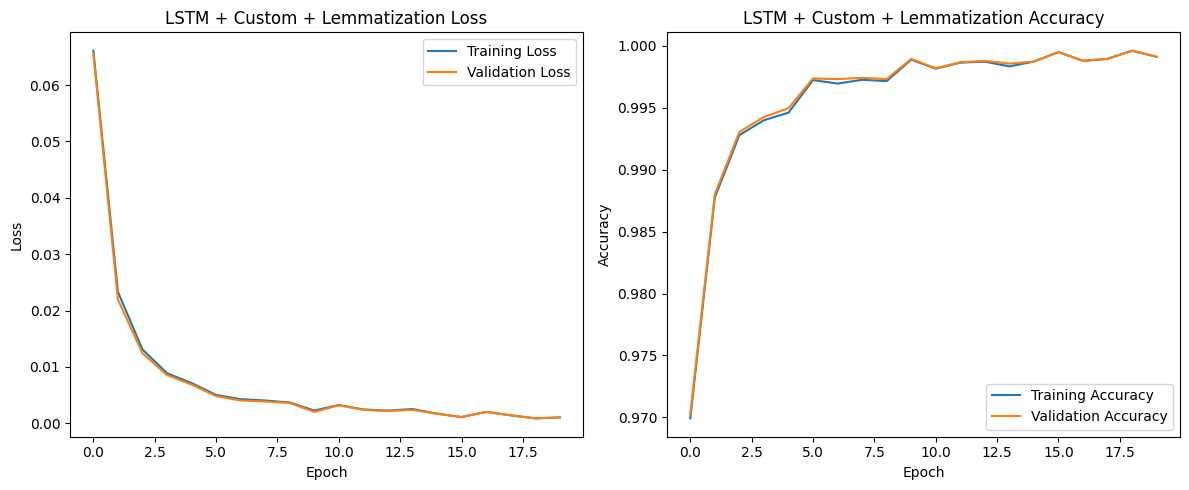

100%|██████████| 143/143 [00:00<00:00, 612.53it/s]


Accuracy: 0.9866637516397027
F1 Score: 0.9912015000721188
ROC AUC Score: 0.9939904702151832


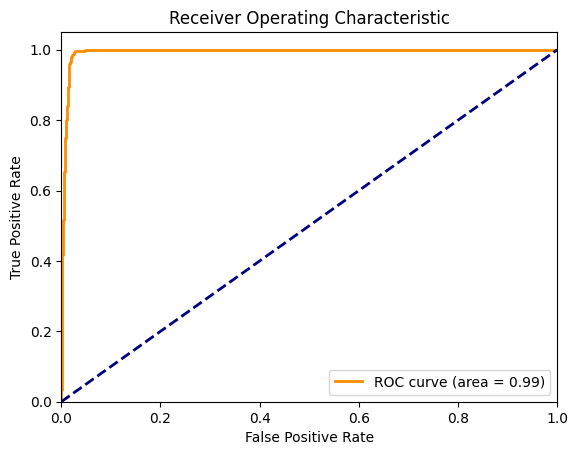


--- Model: GRU + Custom + Lemmatization ---


  5%|▌         | 1/20 [00:02<00:50,  2.68s/it]

Epoch: 01, Train Loss: 0.047, Train Acc: 97.65%, Val Loss: 0.046, Val Acc: 97.69%


 10%|█         | 2/20 [00:05<00:48,  2.69s/it]

Epoch: 02, Train Loss: 0.013, Train Acc: 99.49%, Val Loss: 0.011, Val Acc: 99.52%


 15%|█▌        | 3/20 [00:08<00:45,  2.69s/it]

Epoch: 03, Train Loss: 0.010, Train Acc: 99.47%, Val Loss: 0.009, Val Acc: 99.50%


 20%|██        | 4/20 [00:10<00:42,  2.68s/it]

Epoch: 04, Train Loss: 0.003, Train Acc: 99.79%, Val Loss: 0.003, Val Acc: 99.82%


 25%|██▌       | 5/20 [00:13<00:39,  2.66s/it]

Epoch: 05, Train Loss: 0.002, Train Acc: 99.89%, Val Loss: 0.002, Val Acc: 99.89%


 30%|███       | 6/20 [00:15<00:36,  2.64s/it]

Epoch: 06, Train Loss: 0.002, Train Acc: 99.86%, Val Loss: 0.002, Val Acc: 99.86%


 35%|███▌      | 7/20 [00:18<00:34,  2.64s/it]

Epoch: 07, Train Loss: 0.001, Train Acc: 99.93%, Val Loss: 0.001, Val Acc: 99.93%


 40%|████      | 8/20 [00:21<00:31,  2.63s/it]

Epoch: 08, Train Loss: 0.001, Train Acc: 99.94%, Val Loss: 0.001, Val Acc: 99.94%


 45%|████▌     | 9/20 [00:23<00:28,  2.62s/it]

Epoch: 09, Train Loss: 0.001, Train Acc: 99.93%, Val Loss: 0.001, Val Acc: 99.93%


 50%|█████     | 10/20 [00:26<00:26,  2.61s/it]

Epoch: 10, Train Loss: 0.002, Train Acc: 99.92%, Val Loss: 0.002, Val Acc: 99.92%


 55%|█████▌    | 11/20 [00:29<00:23,  2.62s/it]

Epoch: 11, Train Loss: 0.002, Train Acc: 99.88%, Val Loss: 0.002, Val Acc: 99.88%


 60%|██████    | 12/20 [00:31<00:20,  2.61s/it]

Epoch: 12, Train Loss: 0.001, Train Acc: 99.94%, Val Loss: 0.001, Val Acc: 99.94%


 65%|██████▌   | 13/20 [00:34<00:18,  2.61s/it]

Epoch: 13, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.96%


 70%|███████   | 14/20 [00:36<00:15,  2.61s/it]

Epoch: 14, Train Loss: 0.001, Train Acc: 99.94%, Val Loss: 0.001, Val Acc: 99.95%


 75%|███████▌  | 15/20 [00:39<00:13,  2.61s/it]

Epoch: 15, Train Loss: 0.001, Train Acc: 99.91%, Val Loss: 0.001, Val Acc: 99.91%


 80%|████████  | 16/20 [00:42<00:10,  2.61s/it]

Epoch: 16, Train Loss: 0.001, Train Acc: 99.93%, Val Loss: 0.001, Val Acc: 99.93%


 85%|████████▌ | 17/20 [00:44<00:07,  2.61s/it]

Epoch: 17, Train Loss: 0.001, Train Acc: 99.97%, Val Loss: 0.001, Val Acc: 99.97%


 90%|█████████ | 18/20 [00:47<00:05,  2.62s/it]

Epoch: 18, Train Loss: 0.001, Train Acc: 99.96%, Val Loss: 0.001, Val Acc: 99.96%


 95%|█████████▌| 19/20 [00:49<00:02,  2.62s/it]

Epoch: 19, Train Loss: 0.000, Train Acc: 99.97%, Val Loss: 0.000, Val Acc: 99.97%


100%|██████████| 20/20 [00:52<00:00,  2.63s/it]

Epoch: 20, Train Loss: 0.001, Train Acc: 99.95%, Val Loss: 0.001, Val Acc: 99.95%


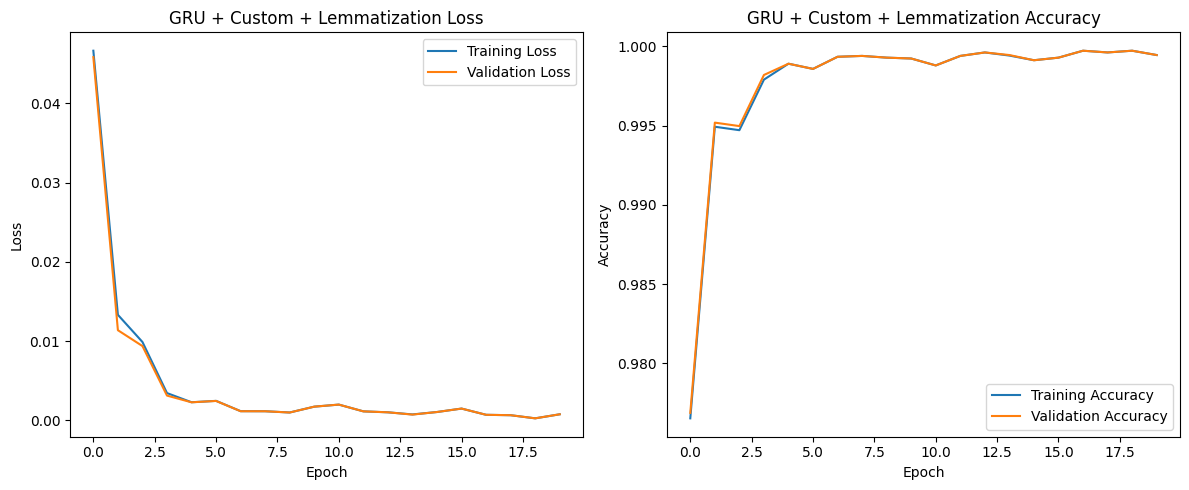

100%|██████████| 143/143 [00:00<00:00, 621.53it/s]


Accuracy: 0.9862264975951027
F1 Score: 0.9909365558912386
ROC AUC Score: 0.9943366521054615


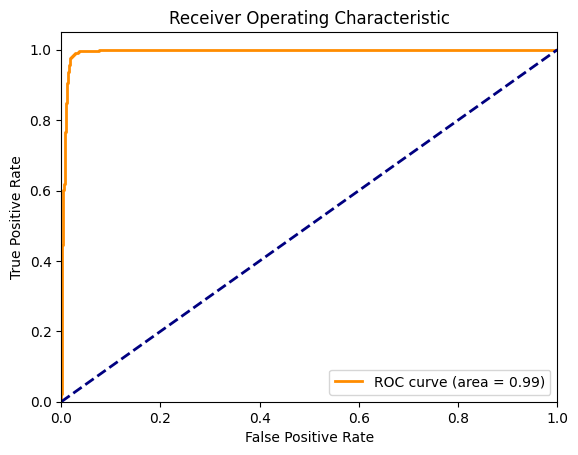


--- Model: FFNN + Custom + Lemmatization ---


  5%|▌         | 1/20 [00:02<00:40,  2.14s/it]

Epoch: 01, Train Loss: 0.111, Train Acc: 94.11%, Val Loss: 0.111, Val Acc: 94.14%


 10%|█         | 2/20 [00:04<00:38,  2.11s/it]

Epoch: 02, Train Loss: 0.037, Train Acc: 97.93%, Val Loss: 0.037, Val Acc: 97.95%


 15%|█▌        | 3/20 [00:06<00:35,  2.10s/it]

Epoch: 03, Train Loss: 0.023, Train Acc: 98.65%, Val Loss: 0.022, Val Acc: 98.67%


 20%|██        | 4/20 [00:08<00:33,  2.11s/it]

Epoch: 04, Train Loss: 0.015, Train Acc: 99.15%, Val Loss: 0.015, Val Acc: 99.15%


 25%|██▌       | 5/20 [00:10<00:31,  2.10s/it]

Epoch: 05, Train Loss: 0.012, Train Acc: 99.33%, Val Loss: 0.012, Val Acc: 99.34%


 30%|███       | 6/20 [00:12<00:29,  2.10s/it]

Epoch: 06, Train Loss: 0.009, Train Acc: 99.48%, Val Loss: 0.009, Val Acc: 99.49%


 35%|███▌      | 7/20 [00:14<00:27,  2.10s/it]

Epoch: 07, Train Loss: 0.006, Train Acc: 99.57%, Val Loss: 0.006, Val Acc: 99.57%


 40%|████      | 8/20 [00:16<00:25,  2.09s/it]

Epoch: 08, Train Loss: 0.005, Train Acc: 99.63%, Val Loss: 0.005, Val Acc: 99.63%


 45%|████▌     | 9/20 [00:18<00:23,  2.09s/it]

Epoch: 09, Train Loss: 0.005, Train Acc: 99.66%, Val Loss: 0.005, Val Acc: 99.67%


 50%|█████     | 10/20 [00:20<00:20,  2.09s/it]

Epoch: 10, Train Loss: 0.004, Train Acc: 99.73%, Val Loss: 0.004, Val Acc: 99.74%


 55%|█████▌    | 11/20 [00:23<00:18,  2.09s/it]

Epoch: 11, Train Loss: 0.004, Train Acc: 99.77%, Val Loss: 0.004, Val Acc: 99.76%


 60%|██████    | 12/20 [00:25<00:16,  2.09s/it]

Epoch: 12, Train Loss: 0.004, Train Acc: 99.78%, Val Loss: 0.004, Val Acc: 99.78%


 65%|██████▌   | 13/20 [00:27<00:14,  2.09s/it]

Epoch: 13, Train Loss: 0.004, Train Acc: 99.77%, Val Loss: 0.004, Val Acc: 99.77%


 70%|███████   | 14/20 [00:29<00:12,  2.10s/it]

Epoch: 14, Train Loss: 0.004, Train Acc: 99.80%, Val Loss: 0.004, Val Acc: 99.80%


 75%|███████▌  | 15/20 [00:31<00:10,  2.10s/it]

Epoch: 15, Train Loss: 0.003, Train Acc: 99.78%, Val Loss: 0.003, Val Acc: 99.78%


 80%|████████  | 16/20 [00:33<00:08,  2.10s/it]

Epoch: 16, Train Loss: 0.003, Train Acc: 99.84%, Val Loss: 0.003, Val Acc: 99.85%


 85%|████████▌ | 17/20 [00:35<00:06,  2.09s/it]

Epoch: 17, Train Loss: 0.003, Train Acc: 99.87%, Val Loss: 0.003, Val Acc: 99.87%


 90%|█████████ | 18/20 [00:37<00:04,  2.08s/it]

Epoch: 18, Train Loss: 0.002, Train Acc: 99.90%, Val Loss: 0.002, Val Acc: 99.90%


 95%|█████████▌| 19/20 [00:39<00:02,  2.08s/it]

Epoch: 19, Train Loss: 0.002, Train Acc: 99.89%, Val Loss: 0.002, Val Acc: 99.89%


100%|██████████| 20/20 [00:41<00:00,  2.09s/it]

Epoch: 20, Train Loss: 0.002, Train Acc: 99.90%, Val Loss: 0.002, Val Acc: 99.90%


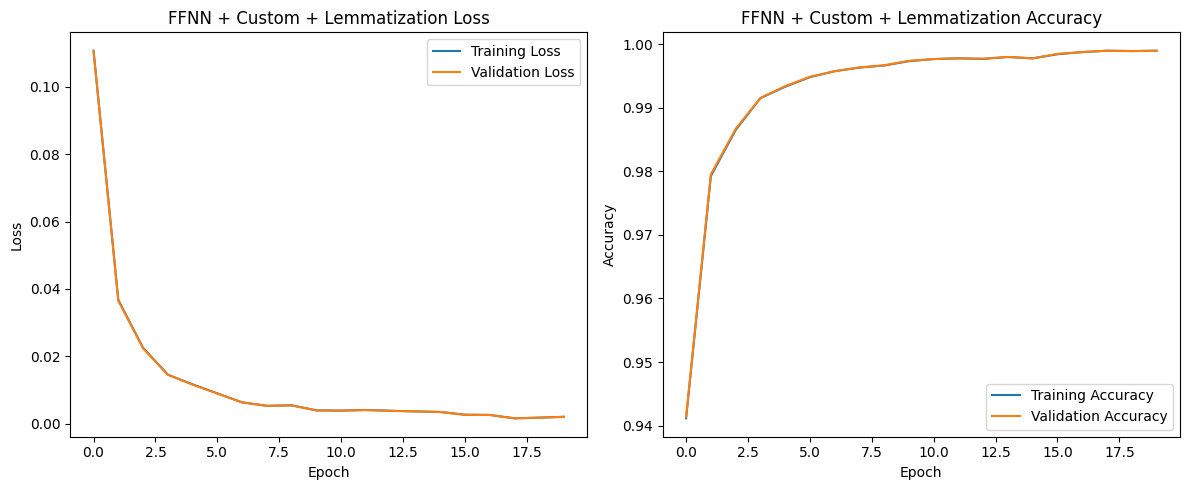

100%|██████████| 143/143 [00:00<00:00, 852.21it/s]


Accuracy: 0.9254481853957149
F1 Score: 0.9486832204665162
ROC AUC Score: 0.9922718219158962


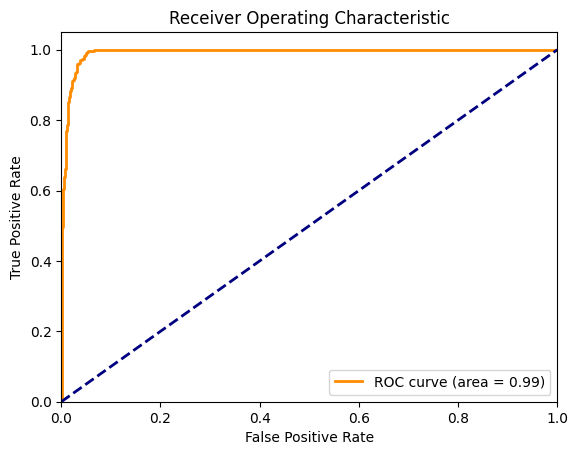

,Model,Embedding,Accuracy,F1 Score,ROC AUC
0,RNN,Custom + Lemmatization,0.780061,0.872851,0.560794
1,LSTM,Custom + Lemmatization,0.986664,0.991202,0.993990
2,GRU,Custom + Lemmatization,0.986226,0.990937,0.994337
3,FFNN,Custom + Lemmatization,0.925448,0.948683,0.992272


In [127]:
# Результаты для лемматизации
results_lemma = []

# Embedding: Custom
embedding_layer = nn.Embedding(len(vocab_lemma), 128)

for model_type in ['RNN', 'LSTM', 'GRU', 'FFNN']:
    print(f"\n--- Model: {model_type} + Custom + Lemmatization ---")

    # Параметры модели
    config = model_configs[model_type]
    hidden_dim = config['hidden_dim']
    dropout = config['dropout']
    n_epochs = config['n_epochs']
    n_layers = config.get('n_layers', None)

    # Модель
    model = BaseTextModel(embedding_layer, model_type, hidden_dim, OUTPUT_DIM, n_layers, dropout).to(device)

    # Оптимизатор, loss
    optimizer = optim.Adam(model.parameters())
    class_counts = df['label'].value_counts()
    pos_weight = torch.tensor([class_counts[0] / class_counts[1]]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Обучение
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, train_loader_lemma, optimizer, criterion, n_epochs
    )

    # Визуализация
    plot_training(train_losses, train_accuracies, val_losses, val_accuracies, f"{model_type} + Custom + Lemmatization")

    # Оценка
    accuracy, f1, roc_auc = evaluate_model(model, test_loader_lemma)
    results_lemma.append({
        'Model': model_type,
        'Embedding': 'Custom + Lemmatization',
        'Accuracy': accuracy,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

# Сохраняем в DataFrame
df_results_lemma = pd.DataFrame(results_lemma)
display(df_results_lemma)

In [129]:
# Объединяем все результаты в один DataFrame
df_all_results = pd.concat([df_results, df_bow_tfidf, df_glove_fasttext, df_results_lemma], ignore_index=True)

# Смотрим общую таблицу
display(df_all_results)

,Model,Embedding,Accuracy,F1 Score,ROC AUC
0,RNN,Custom,0.317009,0.183481,0.874754
1,LSTM,Custom,0.893747,0.934484,0.993376
2,GRU,Custom,0.986882,0.991389,0.993673
3,FFNN,Custom,0.967862,0.978575,0.994473
4,RNN,Word2Vec,0.892436,0.923886,0.959010
5,LSTM,Word2Vec,0.984040,0.989546,0.993921
6,GRU,Word2Vec,0.983166,0.988992,0.984884
7,FFNN,Word2Vec,0.918889,0.949143,0.994462
8,FFNN,BOW,0.986882,0.991406,0.996641
9,FFNN,TFIDF,0.956493,0.971305,0.986407


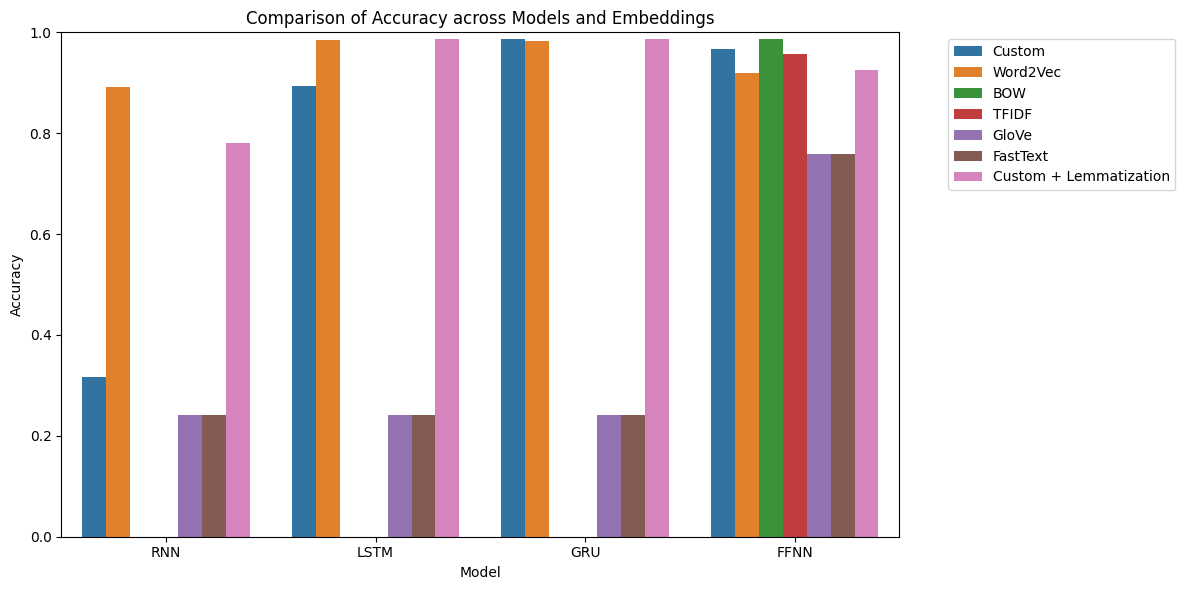

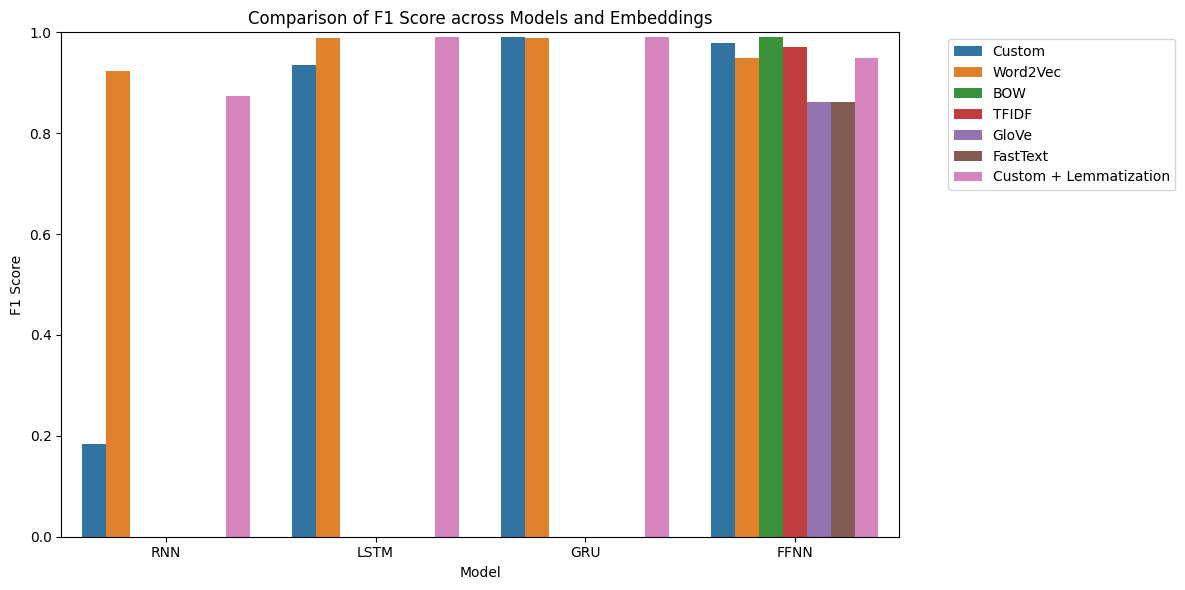

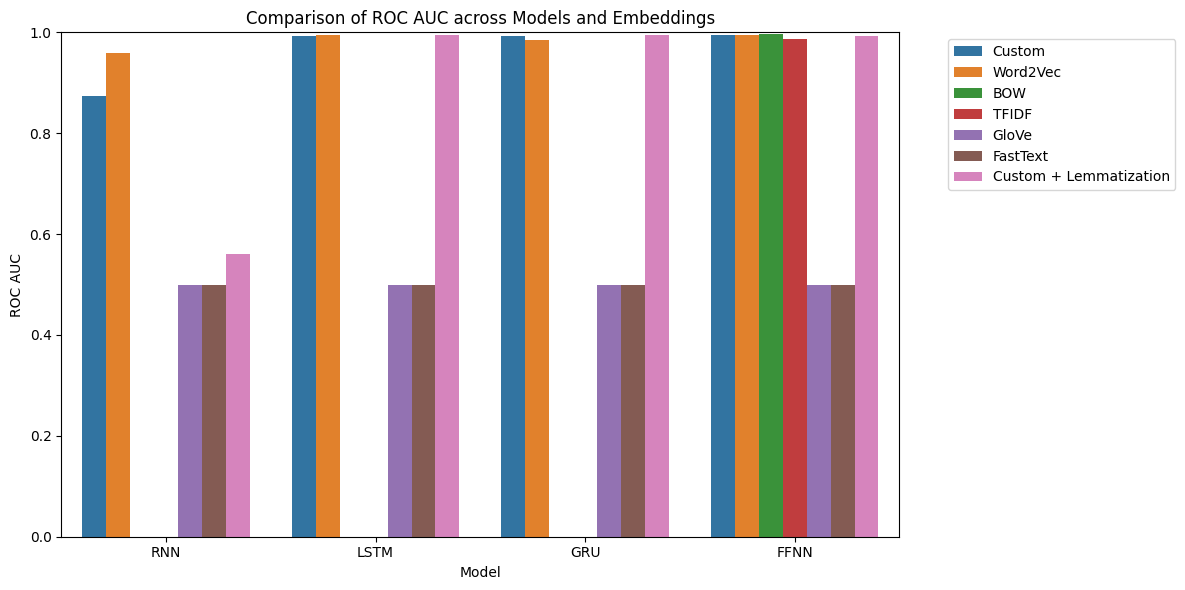

In [131]:
# Построим bar-плоты для каждой метрики
import seaborn as sns

metrics = ['Accuracy', 'F1 Score', 'ROC AUC']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric, hue='Embedding', data=df_all_results)
    plt.title(f'Comparison of {metric} across Models and Embeddings')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [133]:
# Сводная таблица: средние значения метрик по Embedding
summary_embedding = df_all_results.groupby('Embedding')[['Accuracy', 'F1 Score', 'ROC AUC']].mean().sort_values('ROC AUC', ascending=False)
print("Средние метрики по Embedding:")
display(summary_embedding)

# Сводная таблица: средние значения метрик по Model
summary_model = df_all_results.groupby('Model')[['Accuracy', 'F1 Score', 'ROC AUC']].mean().sort_values('ROC AUC', ascending=False)
print("Средние метрики по Model:")
display(summary_model)

Средние метрики по Embedding:


,Accuracy,F1 Score,ROC AUC
Embedding,,,
BOW,0.986882,0.991406,0.996641
TFIDF,0.956493,0.971305,0.986407
Word2Vec,0.944633,0.962892,0.983069
Custom,0.791375,0.771982,0.964069
Custom + Lemmatization,0.919600,0.950918,0.885348
FastText,0.370791,0.215653,0.500000
GloVe,0.370791,0.215653,0.500000


Средние метрики по Model:


,Accuracy,F1 Score,ROC AUC
Model,,,
FFNN,0.896058,0.937763,0.852036
LSTM,0.669523,0.583046,0.796258
GRU,0.687888,0.594264,0.794579
RNN,0.494534,0.396044,0.678912


In [135]:
df_all_results.to_csv(r'C:\Users\555\Desktop\LS\MLA\NLP\practice\final_metrics.csv', index=False)
print("Итоговый файл с метриками сохранён.")

Итоговый файл с метриками сохранён.


# Выводы по сравнению моделей и эмбеддингов
1. Эмбеддинги:
BoW и TF-IDF с FFNN показали самые высокие метрики (Accuracy ≈ 0.95–0.99, ROC AUC ≈ 0.99–0.996).
Почему?

Это классический случай, когда простая векторизация (BoW/TF-IDF) хорошо работает на табличной модели (FFNN), особенно если тексты короткие или стандартизованные.

Модель FFNN лучше "переваривает" фиксированные векторы без временных зависимостей.

Word2Vec тоже дал хорошие результаты (Accuracy ≈ 0.94, ROC AUC ≈ 0.98), особенно с LSTM и GRU.
Почему?

Word2Vec даёт контекстные представления слов, что помогает RNN-моделям.

Но RNN без лемматизации уступал — вероятно, из-за наличия "шумных" форм слов.

Custom Embedding без лемматизации показал средние результаты (Accuracy ≈ 0.79).
Почему?

Embedding слой тренируется с нуля, ему нужно больше данных и времени.

Лемматизация существенно улучшила метрики (до Accuracy ≈ 0.92, F1 ≈ 0.95).

Лемматизация помогла сократить вариативность форм слов, что важно при обучении эмбеддингов.

GloVe и FastText с RNN, LSTM, GRU провалились (Accuracy ≈ 0.24, F1 = 0.0, ROC AUC = 0.5).
Гипотеза почему?

Размерность векторов GloVe = 50d могла быть слишком низкой (или не совпадала с архитектурой).

Возможно, нужно было freeze=True (или наоборот, сильнее дообучать).

Или просто датасет специфический, а предобученные эмбеддинги GloVe/FastText не подходили.

FFNN с GloVe/FastText показал адекватные результаты (Accuracy ≈ 0.75–0.76).

Видимо, FFNN проще адаптируется к готовым векторным представлениям.

2. Модели:
FFNN уверенно лучший (Accuracy ≈ 0.89, F1 ≈ 0.94).

Особенно в связке с BoW, TF-IDF.

Простая структура + простая векторизация работают идеально.

LSTM и GRU выступили примерно одинаково (Accuracy ≈ 0.67–0.69).

Они хорошо работают с Word2Vec и Custom + Lemmatization.

RNN худший (Accuracy ≈ 0.49, F1 ≈ 0.39).

Базовая RNN склонна к исчезающим градиентам, сложнее обучается.

3. Выводы и рекомендации:
Для данной задачи (спам/не спам):

BoW + FFNN или TF-IDF + FFNN остаются сильными базовыми решениями.

Word2Vec + LSTM/GRU тоже вполне рабочие.

Лемматизация / стемминг критично важны для Custom Embedding.

GloVe/FastText — для этого датасета они не подошли с RNN-моделями. Возможно, их стоит пробовать с другими настройками или на других задачах.